In [1]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.python.ops import rnn_cell, rnn
from tensorflow.keras.utils import Sequence
import tensorflow.keras as keras
import tensorflow_probability as tfp
from keras import activations, initializers

import numpy as np
# setting the seed allows for reproducible results
np.random.seed(123)
import pandas as pd


import math
import copy

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

## Before contructing the models: Retrive the data

In [2]:
# tickers of selected assets
dji_selection = ['MMM', 'AAPL', 'WMT', 'DIS', 'GS', 'MCD', 'BA', 'UNH', 'CVX', 'VZ']

In [3]:
# helper function to fetch the data from Yahoo Finance
import yfinance as yf

def get_data(tickers, timeframe:list):
    
    for i, ticker in enumerate(tickers):
        tickerData = yf.Ticker(ticker)
        tickerDf = tickerData.history(period='1d', start=timeframe[0], end=timeframe[1])
        asset_prices = tickerDf[['Close']].rename(columns={'Close':ticker})
        if i==0:
            data = asset_prices
        else:
            data = data.merge(asset_prices, how='outer', left_index=True, right_index=True)
            
    return data

In [4]:
# the data from pre-defined timespan
data = get_data(dji_selection, ['2006-1-1','2022-5-31'])

In [5]:
# first glance at the dataset
data

,MMM,AAPL,WMT,DIS,GS,MCD,BA,UNH,CVX,VZ
Date,,,,,,,,,,
2006-01-03,49.715824,2.279427,32.099594,20.021523,101.857788,20.845430,50.119678,50.853069,31.335972,12.283828
2006-01-04,49.464428,2.286135,32.162094,19.685093,100.450920,21.031992,50.639111,50.976620,31.245819,12.643687
2006-01-05,49.011944,2.268143,31.724649,20.029724,100.411369,21.056868,50.041412,50.820103,30.863928,12.789256
2006-01-06,49.414154,2.326692,31.856577,20.300505,101.834084,21.181246,49.344124,51.816910,31.426136,12.840453
2006-01-09,49.659237,2.319068,31.738525,20.513851,103.059204,21.585463,48.931450,50.581219,31.267023,12.893697
...,...,...,...,...,...,...,...,...,...,...
2022-05-23,142.913361,142.911484,122.068359,105.830002,312.324799,235.399704,124.070000,488.797668,170.173767,49.052860
2022-05-24,144.269440,140.165298,123.591728,101.589996,309.700836,241.848480,119.400002,494.241089,171.085480,50.050312
2022-05-25,144.309036,140.325089,122.835030,103.260002,310.637970,241.344040,122.059998,494.767578,173.830536,50.603355


#### Correlation matrix

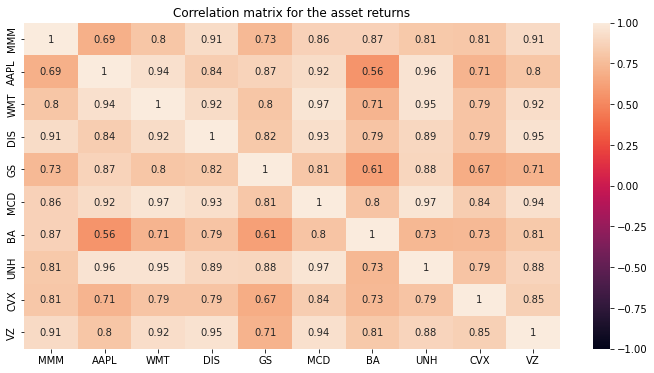

In [6]:
# Increase the size of the heatmap.
plt.figure(figsize=(12, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
plt.title('Correlation matrix for the asset returns')
plt.show()

#### Cumulative returns of the assets

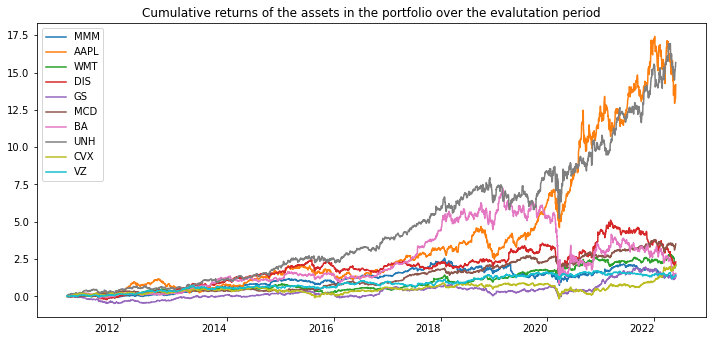

In [7]:
((data.pct_change()['2011':] + 1).cumprod()-1).plot(figsize=(12,6), colormap='tab10', xlabel='', rot=0)
plt.title('Cumulative returns of the assets in the portfolio over the evalutation period')
plt.show()

## 1. Basic RNN Model (with constant weights)

Based on the model from the paper "Deep Learning for Portfolio Optimization" (Zhang et al., 2021). 

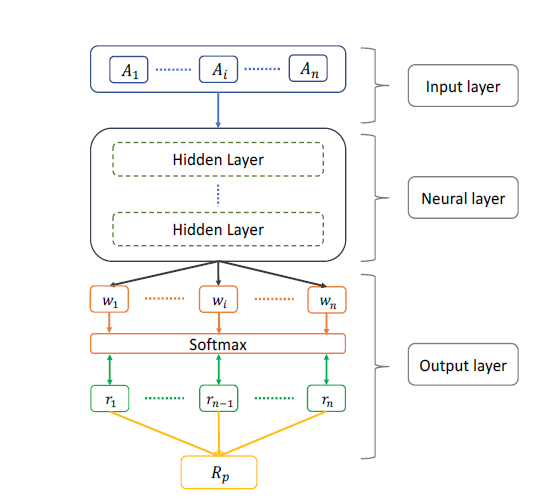

**Figure 1**. Model architecture schematic. Source: "Deep Learning for Portfolio Optimization" (Zhang et al., 2021). 

The input of the model is the prices and the returns of *n* assets in the portfolio on the window of *k* trading periods (here: days) previous to the moment of prediction. Hence, the input shape for a single prediction is (*n* x *k*).  The output of the model is the vector of portfolio weights derived by applying the *softmax* function to the output of the previous layer which is LSTM layer in our case (but convolution with pooling is also potentially applicable).

The idea behind this model is that within the process of training the estimated Sharpe ratio of a portfolio of assets is directly optimized. In other words, the objective to be maximized is the estimated Sharpe ratio, and it is treated as a function from the trainable parameters of the model (weights of the neural network).

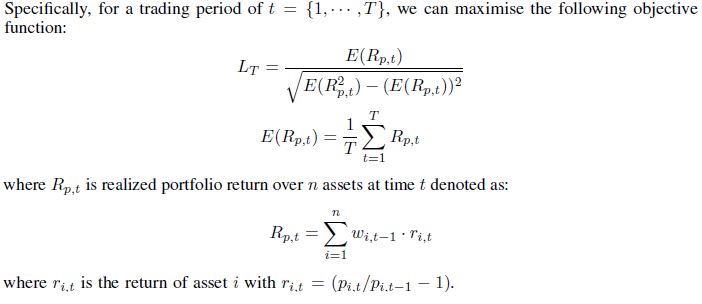

**Figure 2**. Formula for the estimation of a portfolio's Sharpe ratio . Source: "Deep Learning for Portfolio Optimization" (Zhang et al., 2021). 

Above the formula used to estimate the Sharpe ratio in (Zhang et al., 2021). Here lies the difference compared tp the model we implemented. While the authors of the aforementioned paper suggested estimating the expected value of Sharpe ratio using historical values of asset returns (the ones that are known at the moment of prediction), our approach explores the possibility of exploting future values for more precise estimation of the desired value. Since Sharpe ratio has the role of the function to be optimized during the model training, it serves as a loss function of our neural network. In this framework, future values of asset return we use to calculate the values of this loss function serve as the equivalent of labels in a sense that they represent the information that the model "does not know" at the time of prediction and tries to infer using the trained parameters.

In [8]:
class RNN_model:
    
    def __init__(self):
        self.model = None
        
        
    def __build_model(
        self, 
        input_shape, 
        outputs, 
        n_lstm_units,  
        learning_rate):
        '''
        Builds and returns the Deep Neural Network that will compute the allocation ratios
        that optimize the Sharpe Ratio of the portfolio
        
        inputs: input_shape - tuple of the input shape, outputs - the number of assets, 
        n_lstm_units - number of LSTM cells in the layer
        returns: a Deep Neural Network model
        '''
        model = Sequential([
            LSTM(n_lstm_units, input_shape=input_shape),
            Flatten(),
            Dense(
                outputs, 
                activation='softmax', 
            )
        ])

        
        # custom loss function - negated Sharpe ratio
        # while y_pred are portfolio weights generated by the model, y are actually values of future asset returns
        def sharpe_loss(y, y_pred):
            
            first_in_batch = tf.expand_dims(y_pred[0,:], axis=0)
            allocations_lag = tf.concat([first_in_batch, y_pred[:-1,:]], axis=0)
            transaction_costs = self.cost_rate*tf.reduce_sum(abs(y_pred-allocations_lag), axis=1)
            y_pred = tf.expand_dims(y_pred, axis=2)

            # thus the values of the portfolio returns for the k (50) upcoming periods are estimated
            portfolio_returns = tf.matmul(y, y_pred)

            portfolio_returns = tf.squeeze(portfolio_returns, axis=2)
            
            # transacction costs are calculated fot the further adjustment of returns
    
            transaction_costs = tf.tile(
                tf.expand_dims(transaction_costs, axis=1),
                (tf.constant([1,portfolio_returns.shape[-1]], tf.int32))
            )
            portfolio_returns -= transaction_costs

            # from the future portofio return, we estimated expected value of return and its standard deviation
            sharpe = K.mean(portfolio_returns, axis=1) / K.std(portfolio_returns, axis=1)

            # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
            #   we can negate Sharpe (the min of a negated function is its max)

            return -sharpe
            
        opt = keras.optimizers.Adam(learning_rate)
        
        model.compile(loss=sharpe_loss, optimizer='adam')
        return model
    
    def train(self, 
              input_train: pd.DataFrame, 
              future_returns: pd.DataFrame, 
              timeframe: list, 
              batch_size, 
              n_epochs, 
              n_lstm_units,
              learning_rate,
              lb_window=50, 
              la_window=50,
              validation_split=0,
              cost_rate=0.0001):
        
        self.lb_window = lb_window
        self.la_window = la_window
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.n_lstm_units = n_lstm_units
        self.cost_rate = cost_rate       
       
        fit_data = input_train[timeframe[0]:timeframe[1]]
        fut_ret = future_returns[timeframe[0]:timeframe[1]]
        
        self.n_samples = len(fit_data)
        
        fit_data = fit_data.values.reshape(fit_data.shape[0], lb_window, int(len(input_train.columns)/lb_window))
        fut_ret = fut_ret.values.reshape(fut_ret.shape[0], la_window, int(len(fut_ret.columns)/la_window))
        
        n_batches = np.ceil(fit_data.shape[0]/batch_size)
        
        fit_data = tf.cast(tf.constant(fit_data), dtype='float32')
        fut_ret = tf.cast(tf.constant(fut_ret), dtype='float32')
        
        
        
        if self.model is None:
            self.model = self.__build_model(
                (lb_window, fit_data.shape[2]), int(fit_data.shape[2]/2), 
                n_lstm_units, learning_rate,
            )
        

        self.model.fit(fit_data, fut_ret, epochs=n_epochs, 
                       shuffle=False, validation_split=validation_split,)
        
        
    def get_allocations(self, input_pred: pd.DataFrame, timeframe: list):
        '''
        Computes and returns the allocation ratios that optimize the Sharpe over the given data
        
        input: data - DataFrame of historical closing prices of various assets, shape- (lookback window + 1, # of assets)
        
        return: the allocations ratios for each of the given assets
        '''
        pred_data = input_pred[timeframe[0]:timeframe[1]]
        pred_data = pred_data.values.reshape(pred_data.shape[0], self.lb_window, int(len(input_pred.columns)/self.lb_window))
        
        return self.model.predict(pred_data)

### Note: Data Preprocessing

To fit the data in the model, we need to create some additional variables (asset returns) and lag variables for both asset prices and returns in a quantity corresponding to the size of a lookback (and lookahead) window. We opted for a window of 50 trading days.

In [9]:
# helper function for data preprocessing
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
lb_window = la_window = 50

In [11]:
# adding returns and lag variables
data_w_ret = np.concatenate([data.values[1:], data.pct_change().values[1:]], axis=1)
data_reshaped = series_to_supervised(data_w_ret, lb_window-1, 1)
data_reshaped.set_index(data[lb_window:].index, inplace=True)

In [12]:
# making the array of future returns (lookahead window is 50 trading days) - used to calculate the loss
all_returns = data.pct_change()[1:].set_index(data[:-1].index)
future_returns = series_to_supervised(all_returns, 0, la_window)

### Model configuration and training

In [ ]:
# hyperparameter tuning with Optuna
import optuna

val_data = data_reshaped['2011':'2013']
fut_ret_val = future_returns['2011':'2013']

X_val = val_data.values.reshape(val_data.shape[0], lb_window, int(len(data_reshaped.columns)/lb_window))
fr_val = fut_ret_val.values.reshape(fut_ret_val.shape[0], la_window, int(len(future_returns.columns)/la_window))

def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16, 32, 64, 128])
    n_epochs = trial.suggest_int("epochs", 100, 200, step = 10)
    n_lstm_units = trial.suggest_categorical("n_lstm_units", [4, 8, 16, 32, 64, 128, 256, 512]) 
    lr = trial.suggest_float("learning_rate", 0.001, 0.01) 
    
    
    model = RNN_model()
    model.train(
        data_reshaped, 
        future_returns, 
        timeframe=['2006-04-19','2011'], 
        n_epochs=n_epochs, 
        batch_size=batch_size, 
        n_lstm_units=n_lstm_units, 
        learning_rate=lr,
        
    )
    return sharpe(tf.cast(tf.constant(fr_val), dtype='float32'), model.model(X_val))


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

In [13]:
# our set of tuned parameters
model_config = {
    'lb_window':50,
    'la_window':50,
    'validation_split':0,
    'batch_size': 16,
     'n_epochs': 100,
     'n_lstm_units': 128,
     'learning_rate': 0.001,
}

We are using the data of the period up to 2011 as the training set, and the rest of the data as the set to biannual re-training and the evaluation the performance.

In [14]:
base_model = RNN_model()
base_model.train(data_reshaped, future_returns, timeframe=['2006-04-19','2011'], **model_config)

Epoch 1/100
45/45 [==============================] - 4s 26ms/step - loss: -0.0963
Epoch 2/100
45/45 [==============================] - 1s 25ms/step - loss: -0.1189
Epoch 3/100
45/45 [==============================] - 1s 27ms/step - loss: -0.1226
Epoch 4/100
45/45 [==============================] - 1s 27ms/step - loss: -0.1251
Epoch 5/100
45/45 [==============================] - 1s 26ms/step - loss: -0.1269
Epoch 6/100
45/45 [==============================] - 1s 26ms/step - loss: -0.1275
Epoch 7/100
45/45 [==============================] - 1s 27ms/step - loss: -0.1291
Epoch 8/100
45/45 [==============================] - 1s 27ms/step - loss: -0.1289
Epoch 9/100
45/45 [==============================] - 1s 28ms/step - loss: -0.1304
Epoch 10/100
45/45 [==============================] - 1s 28ms/step - loss: -0.1315
Epoch 11/100
45/45 [==============================] - 1s 27ms/step - loss: -0.1321
Epoch 12/100
45/45 [==============================] - 1s 29ms/step - loss: -0.1311
Epoch 13/100


45/45 [==============================] - 2s 44ms/step - loss: -0.1585
Epoch 100/100
45/45 [==============================] - 2s 44ms/step - loss: -0.1583


In [15]:
# example for the results
base_model.get_allocations(data_reshaped, timeframe=['2011','2012'])[:50]

array([[1.44982516e-06, 2.05925032e-01, 1.62698720e-02, 2.94256479e-05,
        3.93194117e-04, 2.68820256e-01, 5.58697047e-06, 1.68343931e-01,
        5.32126650e-02, 2.86998510e-01],
       [1.44668422e-06, 2.05546573e-01, 1.60066336e-02, 2.92884015e-05,
        3.93206428e-04, 2.76635051e-01, 5.60323952e-06, 1.68506086e-01,
        5.18926680e-02, 2.80983448e-01],
       [1.44639830e-06, 2.04599425e-01, 1.59619190e-02, 2.92667555e-05,
        3.87036038e-04, 2.76754797e-01, 5.59898035e-06, 1.69575363e-01,
        5.18381335e-02, 2.80847013e-01],
       [1.53164342e-06, 2.09320024e-01, 1.57156736e-02, 2.97608694e-05,
        3.92970891e-04, 2.81671941e-01, 5.80738106e-06, 1.57529324e-01,
        5.37027791e-02, 2.81630158e-01],
       [1.49605796e-06, 2.07841203e-01, 1.57952998e-02, 2.91205015e-05,
        3.97582422e-04, 2.83734530e-01, 5.67563166e-06, 1.57953575e-01,
        5.28413244e-02, 2.81400204e-01],
       [1.48830929e-06, 2.06731349e-01, 1.57540590e-02, 2.88754254e-05,
   

## 2. RNN model with a stochastic layer (weights trained with Bayes by Backprop)

The models that come next have the same architecture as the one above but the stochastic weights applied before the activation of the output layer (*softmax*). This means that not the constant values of the weights are being adjusted in the training process but the parameters of their (normal) distibution. The assumption taken is that the optimal values of the weights in this layer are independently normally distributed.

The algorithm used to train the weights in the case is called Bayes by Backprop, firstly introduced in "Weight Uncertainty in Neural Networks" (Blundell et al., 2015). Important thing to know is the general form of the cost function used for the model training in the algorithm.

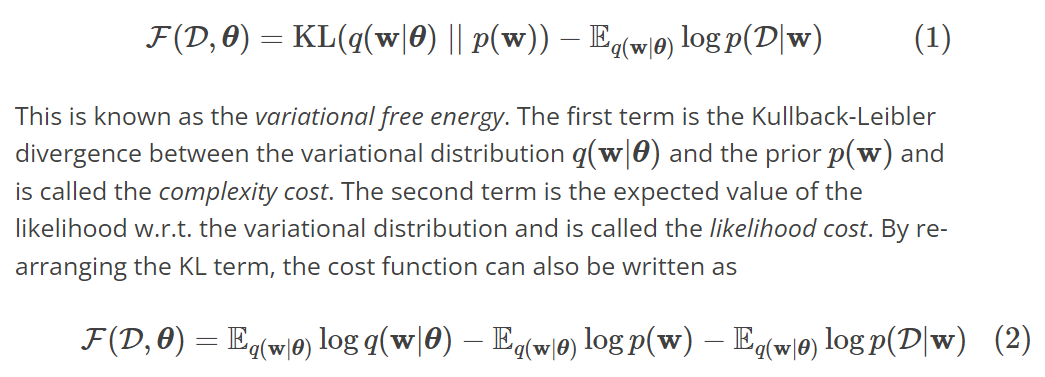

**Figure 3**. Cost function in Bayes by Backprop. Source: Variational inference in Bayesian neural networks (Martin Krasser, http://krasserm.github.io/)

Variation distirution is a distribution of a simplier form (Gaussian) that seeks to best approximate the actual distribution of the model weights in Bayesian framework which is not tractable for the models as complex as neural networks. *Theta* in the formulas above represent the parameters of the weight ditribution (mean and st.dev.) which are the trained parameters. 
The problem we face with out model lies in the third term of (2), expected log-likelihood. In the regular preddiction settings like classification and regression task, log-likelihood is usually represented as cross-entropy and mean squared error, respectively. However, in our case, there are no true values that the model tries to predict, rather it tries to predict the weights that correspond to the predicted maximum value of Sharpe, expected in the future. We took the liberty of replacing the last term in this function with the loss function from our initial model (Sharpe ratio estimated based on future asset returns).

In [16]:
# Dense layer with stochastic weights
class DenseBayesByBackprop(tf.keras.layers.Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 prior_sigma_1=1.5,
                 prior_sigma_2=0.1,
                 prior_pi=0.5, **kwargs):
        self.units = units
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.init_sigma = np.sqrt(self.prior_pi_1 * self.prior_sigma_1 ** 2 +
                                  self.prior_pi_2 * self.prior_sigma_2 ** 2)

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def build(self, input_shape):
        self.w_mu = self.add_weight(name='w_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=initializers.normal(stddev=self.init_sigma),
                                         trainable=True)
        self.b_mu = self.add_weight(name='b_mu',
                                       shape=(self.units,),
                                       initializer=initializers.normal(stddev=self.init_sigma),
                                       trainable=True)
        self.w_rho = self.add_weight(name='w_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=initializers.constant(0.0),
                                          trainable=True)
        self.b_rho = self.add_weight(name='b_rho',
                                        shape=(self.units,),
                                        initializer=initializers.constant(0.0),
                                        trainable=True)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        w_sigma = tf.math.softplus(self.w_rho)
        w = self.w_mu + w_sigma * tf.random.normal(self.w_mu.shape)

        b_sigma = tf.math.softplus(self.b_rho)
        b = self.b_mu + b_sigma * tf.random.normal(self.b_mu.shape)

        # adding complexity cost (see above) to the loss
        self.add_loss(self.kl_loss(w, self.w_mu, w_sigma) +
                      self.kl_loss(b, self.b_mu, b_sigma))

        return self.activation(K.dot(inputs, w) + b)

    def kl_loss(self, weights, mu, sigma):
        variational_dist = tfp.distributions.Normal(mu, sigma)
        return self.kl_weight * K.sum(variational_dist.log_prob(weights) - self.log_prior_prob(weights))

    def log_prior_prob(self, weights):
        comp_1_dist = tfp.distributions.Normal(0.0, self.prior_sigma_1)
        comp_2_dist = tfp.distributions.Normal(0.0, self.prior_sigma_2)
        return K.log(self.prior_pi_1 * comp_1_dist.prob(weights) +
                     self.prior_pi_2 * comp_2_dist.prob(weights))

In [17]:
# similar to the prvious class, but the layer Dense is replaced with DenseBayesByBackprop and new parameters are added
class RNN_model_BayesByBackprop:
    
    def __init__(self):
        self.model = None
        
        
    def __build_model(
        self, 
        input_shape, 
        outputs, 
        n_lstm_units, 
        kl_weight, 
        prior_sigma_1, 
        prior_sigma_2, 
        prior_pi, 
        learning_rate):
   
        model = Sequential([
            LSTM(n_lstm_units, input_shape=input_shape),
            Flatten(),
            DenseBayesByBackprop(
                outputs, 
                kl_weight, 
                activation='softmax', 
                prior_sigma_1=prior_sigma_1,
                prior_sigma_2=prior_sigma_2,
                prior_pi=prior_pi,
            )
        ])

        
        
        def sharpe_loss(y, y_pred):
            
            first_in_batch = tf.expand_dims(y_pred[0,:], axis=0)
            allocations_lag = tf.concat([first_in_batch, y_pred[:-1,:]], axis=0)
            transaction_costs = self.cost_rate*tf.reduce_sum(abs(y_pred-allocations_lag), axis=1)
            y_pred = tf.expand_dims(y_pred, axis=2)

            portfolio_returns = tf.matmul(y, y_pred)

            portfolio_returns = tf.squeeze(portfolio_returns, axis=2)
    
            transaction_costs = tf.tile(
                tf.expand_dims(transaction_costs, axis=1),
                (tf.constant([1,portfolio_returns.shape[-1]], tf.int32))
            )
            portfolio_returns -= transaction_costs

            sharpe = K.mean(portfolio_returns, axis=1) / K.std(portfolio_returns, axis=1)

            return -sharpe

        opt = keras.optimizers.Adam(learning_rate)
        
        model.compile(loss=sharpe_loss, optimizer='adam')
        return model
    
    def train(self, 
              input_train: pd.DataFrame, 
              future_returns: pd.DataFrame, 
              timeframe: list, 
              batch_size, 
              n_epochs, 
              n_lstm_units,
              learning_rate,
              lb_window=50, 
              la_window=50,
              validation_split=0,
              prior_sigma_1=1.5, 
              prior_sigma_2=0.1, 
              prior_pi=0.5,
              cost_rate=0.0001):
        
        self.lb_window = lb_window
        self.la_window = la_window
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.n_lstm_units = n_lstm_units
        self.cost_rate = cost_rate
        
        # data with returns
       
        fit_data = input_train[timeframe[0]:timeframe[1]]
        fut_ret = future_returns[timeframe[0]:timeframe[1]]
        
        self.n_samples = len(fit_data)
        
        fit_data = fit_data.values.reshape(fit_data.shape[0], lb_window, int(len(input_train.columns)/lb_window))
        fut_ret = fut_ret.values.reshape(fut_ret.shape[0], la_window, int(len(fut_ret.columns)/la_window))
        
        n_batches = np.ceil(fit_data.shape[0]/batch_size)
        kl_weight = 1/n_batches
        
        fit_data = tf.cast(tf.constant(fit_data), dtype='float32')
        fut_ret = tf.cast(tf.constant(fut_ret), dtype='float32')
        
        
        
        if self.model is None:
            self.model = self.__build_model(
                (lb_window, fit_data.shape[2]), int(fit_data.shape[2]/2), 
                n_lstm_units, kl_weight, learning_rate,
                prior_sigma_1, prior_sigma_2, prior_pi
            )
        

        self.model.fit(fit_data, fut_ret, epochs=n_epochs, 
                       shuffle=False, validation_split=validation_split,)
        
        
    def get_allocations(self, input_pred: pd.DataFrame, timeframe: list):
        
        pred_data = input_pred[timeframe[0]:timeframe[1]]
        pred_data = pred_data.values.reshape(pred_data.shape[0], self.lb_window, int(len(input_pred.columns)/self.lb_window))
        
        return self.model.predict(pred_data)

### Training of Bayes by Backprop BNN

Bayes by Backprop requires to choose the prior distribution of weights which plays a great role in the model training. Following
Blundell et al. (2015), we chose using a scale mixture of two Gaussian densities as the prior. Each density is zero mean, but differing variances. The parameters of the prior distribution are derived through hyperparameter tuning.

In [ ]:
#  helper function to derive Sharpe raion as an objective function during hyperparameter tuning

def sharpe(y, y_pred):
            
    y_pred = tf.expand_dims(y_pred, axis=2)
    portfolio_returns = tf.matmul(y, y_pred)
    portfolio_returns = tf.squeeze(portfolio_returns, axis=2)

    sharpe = K.mean(portfolio_returns, axis=1) / K.std(portfolio_returns, axis=1)

    return tf.reduce_mean(sharpe)

In [ ]:
# hyperparameter tuning - Bayes by Backprop
import optuna

val_data = data_reshaped['2011':'2013']
fut_ret_val = future_returns['2011':'2013']

lb_window = la_window = 50

X_val = val_data.values.reshape(val_data.shape[0], lb_window, int(len(data_reshaped.columns)/lb_window))
fr_val = fut_ret_val.values.reshape(fut_ret_val.shape[0], la_window, int(len(future_returns.columns)/la_window))

def objective(trial):
    prior_sigma_1=trial.suggest_float("prior_sigma_1", 0.75, 3)
    prior_sigma_2=trial.suggest_float("prior_sigma_2", 0.01, 0.25)
    prior_pi=trial.suggest_float("prior_pi", 0, 1) 

    model = RNN_model_BayesByBackprop()
    model.train(
        data_reshaped, 
        future_returns, 
        timeframe=['2006-04-19','2011'], 
        **model_config,
        prior_sigma_1=prior_sigma_1,
        prior_sigma_2=prior_sigma_2,
        prior_pi=prior_pi
    
    )
    
    sampled_sharpe = np.array([sharpe(tf.cast(tf.constant(fr_val), dtype='float32'), model.model(X_val)) for i in range(100)])
    
    return np.mean(sampled_sharpe)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

In [18]:
# config with the added prameters of the prior
model_config_bbb = {
    'lb_window': 50,
    'la_window': 50,
    'validation_split': 0,
    'batch_size': 128,
    'n_epochs': 100,
    'n_lstm_units': 16,
    'learning_rate': 0.0016,
    'prior_sigma_1': 1.41335,
    'prior_sigma_2': 0.2,
    'prior_pi': 0.1586
}

In [19]:
model_bbb = RNN_model_BayesByBackprop()
model_bbb.train(data_reshaped, future_returns, timeframe=['2006-04-19','2011'], **model_config_bbb)

Epoch 1/100
45/45 [==============================] - 5s 14ms/step - loss: 11.7187
Epoch 2/100
45/45 [==============================] - 1s 15ms/step - loss: 11.2531
Epoch 3/100
45/45 [==============================] - 1s 16ms/step - loss: 10.8853
Epoch 4/100
45/45 [==============================] - 1s 15ms/step - loss: 10.5107
Epoch 5/100
45/45 [==============================] - 1s 16ms/step - loss: 10.1479
Epoch 6/100
45/45 [==============================] - 1s 16ms/step - loss: 9.9447
Epoch 7/100
45/45 [==============================] - 1s 16ms/step - loss: 9.9803
Epoch 8/100
45/45 [==============================] - 1s 16ms/step - loss: 9.5093
Epoch 9/100
45/45 [==============================] - 1s 16ms/step - loss: 9.3956
Epoch 10/100
45/45 [==============================] - 1s 16ms/step - loss: 9.1464
Epoch 11/100
45/45 [==============================] - 1s 16ms/step - loss: 9.0882
Epoch 12/100
45/45 [==============================] - 1s 16ms/step - loss: 9.0061
Epoch 13/100
45/45 [

In [20]:
# if the cell is run multiple times, each time the allocation suggested by the model is different since the weights are stochastic
model_bbb.get_allocations(data_reshaped, timeframe=['2011','2012'])[:50]

array([[0.00268153, 0.05640929, 0.2107081 , 0.24245605, 0.00664563,
        0.2952331 , 0.01581092, 0.1374778 , 0.03042676, 0.00215077],
       [0.0026816 , 0.0564096 , 0.21071371, 0.24245235, 0.00664595,
        0.29522675, 0.01581126, 0.13748042, 0.03042752, 0.00215086],
       [0.00268162, 0.05640966, 0.21071504, 0.24245144, 0.00664603,
        0.29522523, 0.01581134, 0.13748102, 0.03042769, 0.00215088],
       [0.00268152, 0.05640926, 0.21070747, 0.24245651, 0.00664559,
        0.2952338 , 0.01581088, 0.1374775 , 0.03042668, 0.00215076],
       [0.00268153, 0.05640929, 0.21070799, 0.24245617, 0.00664562,
        0.2952333 , 0.01581092, 0.13747773, 0.03042675, 0.00215077],
       [0.0026818 , 0.05641041, 0.21072869, 0.24244225, 0.00664682,
        0.29520974, 0.01581215, 0.13748746, 0.03042954, 0.00215111],
       [0.00268163, 0.0564097 , 0.21071567, 0.24245106, 0.00664607,
        0.29522455, 0.01581137, 0.13748133, 0.03042778, 0.00215089],
       [0.00268155, 0.05640937, 0.2107095

## 3. RNN model with a stochastic layer (weights trained with SGVB)

Library *TensorFlow Probability* contains the inplemetation of the Dense layer with stochastic weights. For training, it exploits the same cost function as the previous algorithm (reformulated ELBO). Nonetheless, it also allows the prior to be trained along with posterior which corresponds to the algorithm called Stochastic Gradient Variational Bayes - SGVB (Kingma & Welling, 2014).

In [21]:
tfd = tfp.distributions


# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])

In [22]:
# base model but DenseVariational instead of Dense layer
class RNN_model_SGVB:
    
    def __init__(self):
        self.model = None
        
        
    def __build_model(
        self, 
        input_shape, 
        outputs, 
        n_lstm_units, 
        kl_weight, 
        learning_rate):
        
        model = Sequential([
            LSTM(n_lstm_units, input_shape=input_shape),
            Flatten(),
            tfp.layers.DenseVariational(
                outputs, 
                posterior_mean_field, 
                prior_trainable,
                kl_weight, 
                activation='softmax', 
            )
        ])

        
        
        def sharpe_loss(y, y_pred):
            
            first_in_batch = tf.expand_dims(y_pred[0,:], axis=0)
            allocations_lag = tf.concat([first_in_batch, y_pred[:-1,:]], axis=0)
            transaction_costs = self.cost_rate*tf.reduce_sum(abs(y_pred-allocations_lag), axis=1)
            y_pred = tf.expand_dims(y_pred, axis=2)

            # thus the values of the portfolio returns for the k (50) upcoming periods are estimated
            portfolio_returns = tf.matmul(y, y_pred)

            portfolio_returns = tf.squeeze(portfolio_returns, axis=2)
    
            transaction_costs = tf.tile(
                tf.expand_dims(transaction_costs, axis=1),
                (tf.constant([1,portfolio_returns.shape[-1]], tf.int32))
            )
            portfolio_returns -= transaction_costs

            # from the future portofio return, we estimated expected value of return and its standard deviation
            sharpe = K.mean(portfolio_returns, axis=1) / K.std(portfolio_returns, axis=1)

            # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
            #   we can negate Sharpe (the min of a negated function is its max)

            return -sharpe
            
        opt = keras.optimizers.Adam(learning_rate)
        
        model.compile(loss=sharpe_loss, optimizer='adam')
        return model
    
    def train(self, 
              input_train: pd.DataFrame, 
              future_returns: pd.DataFrame, 
              timeframe: list, 
              batch_size, 
              n_epochs, 
              n_lstm_units,
              learning_rate,
              lb_window=50, 
              la_window=50,
              validation_split=0,
              cost_rate=0.0001
             ):
        
        self.lb_window = lb_window
        self.la_window = la_window
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.n_lstm_units = n_lstm_units
        self.cost_rate=cost_rate
        
        # data with returns
       
        fit_data = input_train[timeframe[0]:timeframe[1]]
        fut_ret = future_returns[timeframe[0]:timeframe[1]]
        
        self.n_samples = len(fit_data)
        
        fit_data = fit_data.values.reshape(fit_data.shape[0], lb_window, int(len(input_train.columns)/lb_window))
        fut_ret = fut_ret.values.reshape(fut_ret.shape[0], la_window, int(len(fut_ret.columns)/la_window))
        
        n_batches = np.ceil(fit_data.shape[0]/batch_size)
        kl_weight = 1/n_batches
        
        fit_data = tf.cast(tf.constant(fit_data), dtype='float32')
        fut_ret = tf.cast(tf.constant(fut_ret), dtype='float32')
        
        
        
        if self.model is None:
            self.model = self.__build_model(
                (lb_window, fit_data.shape[2]), int(fit_data.shape[2]/2), 
                n_lstm_units, kl_weight, learning_rate
            )
        

        self.model.fit(fit_data, fut_ret, epochs=n_epochs, 
                       shuffle=False, validation_split=validation_split,)
        
        
    def get_allocations(self, input_pred: pd.DataFrame, timeframe: list):
       
        pred_data = input_pred[timeframe[0]:timeframe[1]]
        pred_data = pred_data.values.reshape(pred_data.shape[0], self.lb_window, int(len(input_pred.columns)/self.lb_window))
        
        return self.model.predict(pred_data)

In [23]:
model_sgvb = RNN_model_SGVB()
model_sgvb.train(data_reshaped, future_returns, timeframe=['2006-04-19','2011'], **model_config)

Epoch 1/100
45/45 [==============================] - 6s 35ms/step - loss: -0.0664
Epoch 2/100
45/45 [==============================] - 2s 38ms/step - loss: -0.0482
Epoch 3/100
45/45 [==============================] - 2s 39ms/step - loss: -0.0332
Epoch 4/100
45/45 [==============================] - 2s 41ms/step - loss: -0.0685
Epoch 5/100
45/45 [==============================] - 2s 43ms/step - loss: -0.0562
Epoch 6/100
45/45 [==============================] - 2s 47ms/step - loss: -0.0596
Epoch 7/100
45/45 [==============================] - 2s 50ms/step - loss: -0.0656
Epoch 8/100
45/45 [==============================] - 2s 50ms/step - loss: -0.0728
Epoch 9/100
45/45 [==============================] - 2s 49ms/step - loss: -0.0589
Epoch 10/100
45/45 [==============================] - 2s 49ms/step - loss: -0.0562
Epoch 11/100
45/45 [==============================] - 2s 50ms/step - loss: -0.0681
Epoch 12/100
45/45 [==============================] - 2s 52ms/step - loss: -0.0575
Epoch 13/100


45/45 [==============================] - 3s 69ms/step - loss: -0.0680
Epoch 100/100
45/45 [==============================] - 3s 70ms/step - loss: -0.0828


In [24]:
# if the cell is run multiple times, each time the allocation suggested by the model is different since the weights are stochastic
model_sgvb.get_allocations(data_reshaped, timeframe=['2011','2012'])[:50]

array([[6.2597707e-08, 9.9983704e-01, 3.8444643e-09, 3.9921738e-07,
        3.9351451e-09, 6.8101690e-06, 8.6880254e-09, 8.4799149e-07,
        3.1510519e-12, 1.5480639e-04],
       [6.2575864e-08, 9.9983704e-01, 3.8432035e-09, 3.9896082e-07,
        3.9344172e-09, 6.8066042e-06, 8.6897485e-09, 8.4803594e-07,
        3.1497719e-12, 1.5478246e-04],
       [6.3522783e-08, 9.9983573e-01, 3.8877590e-09, 4.0929831e-07,
        3.9580916e-09, 6.9751163e-06, 8.6065866e-09, 8.4762490e-07,
        3.1911539e-12, 1.5578335e-04],
       [6.2953767e-08, 9.9983656e-01, 3.8611514e-09, 4.0308069e-07,
        3.9440473e-09, 6.8734171e-06, 8.6565271e-09, 8.4784068e-07,
        3.1665042e-12, 1.5518650e-04],
       [6.3143986e-08, 9.9983621e-01, 3.8696801e-09, 4.0512111e-07,
        3.9485246e-09, 6.9075459e-06, 8.6398639e-09, 8.4782829e-07,
        3.1741463e-12, 1.5538785e-04],
       [6.2048329e-08, 9.9983776e-01, 3.8183710e-09, 3.9324544e-07,
        3.9212344e-09, 6.7131655e-06, 8.7370209e-09, 8.48

## 4. Stochastic RNN model with Flipout

*TensorFlow Probability* also offers the implementation of the Dense layer with Flipout estimator. Flipout is presented in the paper of Wen et al. (2018). This method decorrelates the gradients within a mini-batch during the model training by implicitly sampling pseudo-independent weight perturbations for each example. As the result, the ideal linear variance reduction for fully connected networks, convolutional networks, and RNNs is achieved.

In [25]:
# layer DenseFlipout in the place of Dense
class RNN_model_Flipout:
    
    def __init__(self):
        self.model = None
        
        
    def __build_model(
        self, 
        input_shape, 
        outputs, 
        n_lstm_units, 
        learning_rate):
        '''
        Builds and returns the Deep Neural Network that will compute the allocation ratios
        that optimize the Sharpe Ratio of the portfolio
        
        inputs: input_shape - tuple of the input shape, outputs - the number of assets
        returns: a Deep Neural Network model
        '''
        model = Sequential([
            LSTM(n_lstm_units, input_shape=input_shape),
            Flatten(),
            tfp.layers.DenseFlipout(
                outputs,  
                activation='softmax', 
            )
        ])

        
        
        def sharpe_loss_flipout(y, y_pred):
            
            first_in_batch = tf.expand_dims(y_pred[0,:], axis=0)
            allocations_lag = tf.concat([first_in_batch, y_pred[:-1,:]], axis=0)
            transaction_costs = self.cost_rate*tf.reduce_sum(abs(y_pred-allocations_lag), axis=1)
            y_pred = tf.expand_dims(y_pred, axis=2)

            # thus the values of the portfolio returns for the k (50) upcoming periods are estimated
            portfolio_returns = tf.matmul(y, y_pred)

            portfolio_returns = tf.squeeze(portfolio_returns, axis=2)
    
            transaction_costs = tf.tile(
                tf.expand_dims(transaction_costs, axis=1),
                (tf.constant([1,portfolio_returns.shape[-1]], tf.int32))
            )
            portfolio_returns -= transaction_costs

            # from the future portofio return, we estimated expected value of return and its standard deviation
            sharpe = K.mean(portfolio_returns, axis=1) / K.std(portfolio_returns, axis=1)

            # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
            #   we can negate Sharpe (the min of a negated function is its max)
            
            # additional conponents of loss are divided by the size of input and divided


            return -sharpe + sum(self.model.losses)/self.n_samples
            
        
        model.compile(loss=sharpe_loss_flipout, optimizer='adam')
        return model
    
    def train(self, 
              input_train: pd.DataFrame, 
              future_returns: pd.DataFrame, 
              timeframe: list, 
              batch_size, 
              n_epochs, 
              n_lstm_units,
              learning_rate,
              lb_window=50, 
              la_window=50,
              validation_split=0,
              cost_rate = 0.0001
             ):
        
        self.lb_window = lb_window
        self.la_window = la_window
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.n_lstm_units = n_lstm_units
        self.cost_rate = 0.0001
        
        
        # data with returns
       
        fit_data = input_train[timeframe[0]:timeframe[1]]
        fut_ret = future_returns[timeframe[0]:timeframe[1]]
        
        self.n_samples = len(fit_data)
        
        fit_data = fit_data.values.reshape(fit_data.shape[0], lb_window, int(len(input_train.columns)/lb_window))
        fut_ret = fut_ret.values.reshape(fut_ret.shape[0], la_window, int(len(fut_ret.columns)/la_window))
        
        n_batches = np.ceil(fit_data.shape[0]/batch_size)
        
        fit_data = tf.cast(tf.constant(fit_data), dtype='float32')
        fut_ret = tf.cast(tf.constant(fut_ret), dtype='float32')
        
        
        
        if self.model is None:
            self.model = self.__build_model(
                (lb_window, fit_data.shape[2]), int(fit_data.shape[2]/2), 
                n_lstm_units, learning_rate
            )
        

        self.model.fit(fit_data, fut_ret, epochs=n_epochs, 
                       shuffle=False, validation_split=validation_split,)
        
        
    def get_allocations(self, input_pred: pd.DataFrame, timeframe: list):
        '''
        Computes and returns the allocation ratios that optimize the Sharpe over the given data
        
        input: data - DataFrame of historical closing prices of various assets, shape- (lookback window + 1, # of assets)
        
        return: the allocations ratios for each of the given assets
        '''
        pred_data = input_pred[timeframe[0]:timeframe[1]]
        pred_data = pred_data.values.reshape(pred_data.shape[0], self.lb_window, int(len(input_pred.columns)/self.lb_window))
        
        return self.model.predict(pred_data)

In [26]:
model_flipout = RNN_model_Flipout()
model_flipout.train(data_reshaped, future_returns, timeframe=['2006-04-19','2011'], **model_config)

C:\Users\Makar\anaconda3\envs\master_thesis\lib\site-packages\tensorflow_probability\python\layers\util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
C:\Users\Makar\anaconda3\envs\master_thesis\lib\site-packages\tensorflow_probability\python\layers\util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/100
45/45 [==============================] - 6s 37ms/step - loss: 3216.3704
Epoch 2/100
45/45 [==============================] - 2s 43ms/step - loss: 3157.9009
Epoch 3/100
45/45 [==============================] - 2s 53ms/step - loss: 3100.8252
Epoch 4/100
45/45 [==============================] - 2s 55ms/step - loss: 3044.4548
Epoch 5/100
45/45 [==============================] - 3s 56ms/step - loss: 2988.4927
Epoch 6/100
45/45 [==============================] - 3s 56ms/step - loss: 2932.8022
Epoch 7/100
45/45 [==============================] - 3s 59ms/step - loss: 2877.3186
Epoch 8/100
45/45 [==============================] - 3s 60ms/step - loss: 2822.0178
Epoch 9/100
45/45 [==============================] - 3s 64ms/step - loss: 2766.8872
Epoch 10/100
45/45 [==============================] - 3s 66ms/step - loss: 2711.9272
Epoch 11/100
45/45 [==============================] - 3s 63ms/step - loss: 2657.1394
Epoch 12/100
45/45 [==============================] - 3s 61ms/step - loss:

45/45 [==============================] - 3s 66ms/step - loss: 9.4011
Epoch 99/100
45/45 [==============================] - 3s 63ms/step - loss: 7.9861
Epoch 100/100
45/45 [==============================] - 3s 65ms/step - loss: 6.7539


In [27]:
# if the cell is run multiple times, each time the allocation suggested by the model is different since the weights are stochastic
model_flipout.get_allocations(data_reshaped, timeframe=['2011','2012'])[:50]

array([[1.64521873e-01, 6.25710011e-01, 6.24757167e-03, 2.05344334e-03,
        2.61210985e-02, 1.06888898e-02, 3.49362614e-04, 4.28004451e-02,
        3.26702185e-03, 1.18240260e-01],
       [2.05023400e-02, 3.23367827e-02, 8.05907184e-04, 4.92694899e-02,
        8.88683935e-05, 1.18028738e-01, 1.79371331e-03, 1.32819125e-03,
        2.79791001e-03, 7.73048103e-01],
       [8.93074051e-02, 1.40646711e-01, 4.56801476e-03, 2.14860156e-01,
        1.41329169e-02, 5.14287293e-01, 7.80809065e-03, 5.18519850e-03,
        9.18330904e-03, 2.08787005e-05],
       [1.35056004e-02, 3.01316404e-03, 7.71124614e-03, 7.28882209e-04,
        3.19949053e-02, 7.09291935e-01, 2.20555048e-02, 4.07220013e-02,
        4.81412224e-02, 1.22835480e-01],
       [4.76331403e-03, 3.70848458e-03, 1.83167942e-02, 8.98369879e-04,
        3.93869989e-02, 8.73711288e-01, 2.71584634e-02, 6.51179301e-03,
        2.04906296e-02, 5.05374093e-03],
       [2.85157263e-02, 7.49796107e-02, 3.77811375e-03, 8.34639941e-04,
   

## 5. Evaluation of the models

We apply the models to produce an updated allocation of assets each day. Initially, the BNNs are trained on the data up to the beginning of 2011. Since then, the evaluation period starts: the performance of the portfolios is reported along with the perofrmance of the baselines and the models are retrained with all the available data every two years.

In [29]:
from pypfopt.efficient_frontier import EfficientFrontier, EfficientCVaR

# prepare the lists to store the weights produced by the various methods to aggregate the BNN output 
# and the SDs of original output
models = [RNN_model(), RNN_model_BayesByBackprop(), RNN_model_SGVB(), RNN_model_Flipout()]
portfolio_weights_mean = [None, None, None, None]
portfolio_weights_ps = [None, None, None]
portfolio_weights_cvar = [None, None, None]
weight_stds = [None, None, None]

import tqdm
for year in range(2010, 2021, 2):
    for j, buildup in enumerate(models):
        model = buildup
        if j==1:            
            model.train(data_reshaped, future_returns, timeframe=['2006-03-16',str(year)], **model_config_bbb)
        else:
            model.train(data_reshaped, future_returns, timeframe=['2006-03-16',str(year)], **model_config) 
        if j==0:
            new_values = model.get_allocations(data_reshaped, timeframe=[str(year+1),str(year+2)])     
        else:
            # sampling BNN output given each input point
            samples = []
            for k in tqdm.tqdm(range(1000)):
                sampled_values = model.get_allocations(data_reshaped, timeframe=[str(year+1),str(year+2)]) 
                samples.append(sampled_values)
                
            # mean outputs of BNNs
            new_values = np.mean(samples, axis=0)
            
            # store the SDs of outputted  weights
            std_values = np.std(samples, axis=0)
            if weight_stds[j-1] is None:
                weight_stds[j-1] = std_values
            else:
                weight_stds[j-1] = np.append(weight_stds[j-1], std_values, axis=0)
                
            # CVaR optimization with the use of BNN output 
            hist_returns = data_reshaped[str(year+1):str(year+2)]
            hist_returns = hist_returns.values.reshape(
                hist_returns.shape[0], 50, int(len(hist_returns.columns)/50)
            )[:,:,10:]
            hist_returns = np.swapaxes(hist_returns, 1, 2)
            mean_returns = hist_returns.mean(axis=2)
            stacked_samples = np.swapaxes(np.stack(samples, axis=0), 0, 1)
            
            # mean historical returns are multiplied by the sampled weights to synthesize a distibution
            asset_returns_distributions = np.einsum('ijk,ik->ijk', stacked_samples, mean_returns) 
            all_weights = []
            for i in range(len(asset_returns_distributions)):
                ef = EfficientCVaR(expected_returns=None, returns=asset_returns_distributions[i,:,:])
                weights = np.array(list(
                    ef.min_cvar().values()
                ))
                all_weights.append(weights)
            new_values_cvar = np.stack(all_weights, axis=0)
            
            if portfolio_weights_cvar[j-1] is None:
                portfolio_weights_cvar[j-1] = new_values_cvar
            else:
                portfolio_weights_cvar[j-1] = np.append(portfolio_weights_cvar[j-1], new_values_cvar, axis=0)
            
            # selection of the asset allocation with the max esimated Sharpe ratiob
            portfolio_returns = np.matmul(stacked_samples, hist_returns)
            sharpes = np.mean(portfolio_returns, axis=2) / np.std(portfolio_returns, axis=2)
            indices_of_best = np.argmax(sharpes, axis=1)    
            new_values_ps = np.stack(
                [stacked_samples[i, indices_of_best[i],:] for i in range(len(stacked_samples))], axis=0
            )
            if portfolio_weights_ps[j-1] is None:
                portfolio_weights_ps[j-1] = new_values_ps
            else:
                portfolio_weights_ps[j-1] = np.append(portfolio_weights_ps[j-1], new_values_ps, axis=0)
        if portfolio_weights_mean[j] is None:
            portfolio_weights_mean[j] = new_values
        else:
            portfolio_weights_mean[j] = np.append(portfolio_weights_mean[j], new_values, axis=0)

Epoch 1/100
38/38 [==============================] - 3s 29ms/step - loss: -0.0789
Epoch 2/100
38/38 [==============================] - 1s 27ms/step - loss: -0.1180
Epoch 3/100
38/38 [==============================] - 2s 41ms/step - loss: -0.1214
Epoch 4/100
38/38 [==============================] - 1s 28ms/step - loss: -0.1238
Epoch 5/100
38/38 [==============================] - 1s 29ms/step - loss: -0.1255
Epoch 6/100
38/38 [==============================] - 1s 29ms/step - loss: -0.1265
Epoch 7/100
38/38 [==============================] - 1s 30ms/step - loss: -0.1281
Epoch 8/100
38/38 [==============================] - 1s 33ms/step - loss: -0.1303
Epoch 9/100
38/38 [==============================] - 1s 30ms/step - loss: -0.1308
Epoch 10/100
38/38 [==============================] - 1s 31ms/step - loss: -0.1319
Epoch 11/100
38/38 [==============================] - 1s 30ms/step - loss: -0.1324
Epoch 12/100
38/38 [==============================] - 1s 29ms/step - loss: -0.1331
Epoch 13/100


38/38 [==============================] - 2s 39ms/step - loss: -0.1569
Epoch 100/100
38/38 [==============================] - 2s 41ms/step - loss: -0.1608
Epoch 1/100
38/38 [==============================] - 5s 15ms/step - loss: 15.5847
Epoch 2/100
38/38 [==============================] - 1s 15ms/step - loss: 14.7366
Epoch 3/100
38/38 [==============================] - 1s 16ms/step - loss: 14.6266
Epoch 4/100
38/38 [==============================] - 1s 16ms/step - loss: 14.1838
Epoch 5/100
38/38 [==============================] - 1s 15ms/step - loss: 13.7202
Epoch 6/100
38/38 [==============================] - 1s 16ms/step - loss: 13.4319
Epoch 7/100
38/38 [==============================] - 1s 16ms/step - loss: 13.1421
Epoch 8/100
38/38 [==============================] - 1s 18ms/step - loss: 12.7859
Epoch 9/100
38/38 [==============================] - 1s 17ms/step - loss: 12.8435
Epoch 10/100
38/38 [==============================] - 1s 18ms/step - loss: 12.3741
Epoch 11/100
38/38 [=====

38/38 [==============================] - 1s 26ms/step - loss: 9.4085
Epoch 99/100
38/38 [==============================] - 1s 30ms/step - loss: 9.4086
Epoch 100/100
38/38 [==============================] - 1s 25ms/step - loss: 9.5605


100%|██████████| 1000/1000 [02:32<00:00,  6.58it/s]


Epoch 1/100
38/38 [==============================] - 5s 32ms/step - loss: -0.0474
Epoch 2/100
38/38 [==============================] - 1s 38ms/step - loss: -0.0603
Epoch 3/100
38/38 [==============================] - 2s 40ms/step - loss: -0.0459
Epoch 4/100
38/38 [==============================] - 1s 36ms/step - loss: -0.0520
Epoch 5/100
38/38 [==============================] - 1s 35ms/step - loss: -0.0600
Epoch 6/100
38/38 [==============================] - 1s 35ms/step - loss: -0.0731
Epoch 7/100
38/38 [==============================] - 1s 36ms/step - loss: -0.0459
Epoch 8/100
38/38 [==============================] - 1s 36ms/step - loss: -0.0415
Epoch 9/100
38/38 [==============================] - 1s 37ms/step - loss: -0.0129
Epoch 10/100
38/38 [==============================] - 1s 37ms/step - loss: -0.0462
Epoch 11/100
38/38 [==============================] - 1s 38ms/step - loss: -0.0617
Epoch 12/100
38/38 [==============================] - 2s 41ms/step - loss: -0.0261
Epoch 13/100


38/38 [==============================] - 5s 133ms/step - loss: -0.0902
Epoch 100/100
38/38 [==============================] - 5s 126ms/step - loss: -0.0633


100%|██████████| 1000/1000 [14:57<00:00,  1.11it/s]


Epoch 1/100
38/38 [==============================] - 5s 39ms/step - loss: 3218.4651
Epoch 2/100
38/38 [==============================] - 2s 44ms/step - loss: 3168.9783
Epoch 3/100
38/38 [==============================] - 2s 46ms/step - loss: 3120.5879
Epoch 4/100
38/38 [==============================] - 2s 51ms/step - loss: 3072.8054
Epoch 5/100
38/38 [==============================] - 2s 57ms/step - loss: 3025.3901
Epoch 6/100
38/38 [==============================] - 2s 62ms/step - loss: 2978.2144
Epoch 7/100
38/38 [==============================] - 3s 69ms/step - loss: 2931.2144
Epoch 8/100
38/38 [==============================] - 3s 77ms/step - loss: 2884.3589
Epoch 9/100
38/38 [==============================] - 3s 90ms/step - loss: 2837.6316
Epoch 10/100
38/38 [==============================] - 4s 96ms/step - loss: 2791.0244
Epoch 11/100
38/38 [==============================] - 4s 97ms/step - loss: 2744.5369
Epoch 12/100
38/38 [==============================] - 4s 101ms/step - loss

38/38 [==============================] - 6s 147ms/step - loss: 77.3623
Epoch 98/100
38/38 [==============================] - 6s 150ms/step - loss: 70.6531
Epoch 99/100
38/38 [==============================] - 5s 142ms/step - loss: 64.3898
Epoch 100/100
38/38 [==============================] - 6s 145ms/step - loss: 58.5656


100%|██████████| 1000/1000 [16:32<00:00,  1.01it/s]


Epoch 1/100
54/54 [==============================] - 2s 36ms/step - loss: -0.1385
Epoch 2/100
54/54 [==============================] - 2s 37ms/step - loss: -0.1298
Epoch 3/100
54/54 [==============================] - 2s 42ms/step - loss: -0.1382
Epoch 4/100
54/54 [==============================] - 3s 53ms/step - loss: -0.1385
Epoch 5/100
54/54 [==============================] - 3s 55ms/step - loss: -0.1408
Epoch 6/100
54/54 [==============================] - 3s 58ms/step - loss: -0.1364
Epoch 7/100
54/54 [==============================] - 4s 66ms/step - loss: -0.1349
Epoch 8/100
54/54 [==============================] - 4s 76ms/step - loss: -0.1322
Epoch 9/100
54/54 [==============================] - 5s 88ms/step - loss: -0.1308
Epoch 10/100
54/54 [==============================] - 5s 90ms/step - loss: -0.1329
Epoch 11/100
54/54 [==============================] - 5s 99ms/step - loss: -0.1373
Epoch 12/100
54/54 [==============================] - 6s 109ms/step - loss: -0.1391
Epoch 13/100

54/54 [==============================] - 1s 15ms/step - loss: 9.3361
Epoch 4/100
54/54 [==============================] - 1s 15ms/step - loss: 9.3919
Epoch 5/100
54/54 [==============================] - 1s 16ms/step - loss: 9.3735
Epoch 6/100
54/54 [==============================] - 1s 13ms/step - loss: 9.3173
Epoch 7/100
54/54 [==============================] - 1s 14ms/step - loss: 9.0970
Epoch 8/100
54/54 [==============================] - 1s 14ms/step - loss: 9.1194
Epoch 9/100
54/54 [==============================] - 1s 14ms/step - loss: 9.4080
Epoch 10/100
54/54 [==============================] - 1s 14ms/step - loss: 9.1876
Epoch 11/100
54/54 [==============================] - 1s 14ms/step - loss: 9.2055
Epoch 12/100
54/54 [==============================] - 1s 14ms/step - loss: 9.1361
Epoch 13/100
54/54 [==============================] - 1s 14ms/step - loss: 9.2829
Epoch 14/100
54/54 [==============================] - 1s 14ms/step - loss: 9.0787
Epoch 15/100
54/54 [===============

100%|██████████| 1000/1000 [01:42<00:00,  9.72it/s]


Epoch 1/100
54/54 [==============================] - 2s 33ms/step - loss: -0.0866
Epoch 2/100
54/54 [==============================] - 2s 34ms/step - loss: -0.0888
Epoch 3/100
54/54 [==============================] - 2s 34ms/step - loss: -0.0566
Epoch 4/100
54/54 [==============================] - 2s 35ms/step - loss: -0.0765
Epoch 5/100
54/54 [==============================] - 2s 36ms/step - loss: -0.0742
Epoch 6/100
54/54 [==============================] - 2s 34ms/step - loss: -0.0798
Epoch 7/100
54/54 [==============================] - 2s 34ms/step - loss: -0.0639
Epoch 8/100
54/54 [==============================] - 2s 34ms/step - loss: -0.0614
Epoch 9/100
54/54 [==============================] - 2s 34ms/step - loss: -0.0816
Epoch 10/100
54/54 [==============================] - 2s 34ms/step - loss: -0.0762
Epoch 11/100
54/54 [==============================] - 2s 34ms/step - loss: -0.0699
Epoch 12/100
54/54 [==============================] - 2s 34ms/step - loss: -0.0713
Epoch 13/100


54/54 [==============================] - 2s 36ms/step - loss: -0.0882
Epoch 100/100
54/54 [==============================] - 2s 34ms/step - loss: -0.0889


100%|██████████| 1000/1000 [05:04<00:00,  3.28it/s]


Epoch 1/100
54/54 [==============================] - 2s 37ms/step - loss: 52.1141
Epoch 2/100
54/54 [==============================] - 2s 35ms/step - loss: 45.2163
Epoch 3/100
54/54 [==============================] - 2s 35ms/step - loss: 39.0501
Epoch 4/100
54/54 [==============================] - 2s 35ms/step - loss: 33.5673
Epoch 5/100
54/54 [==============================] - 2s 35ms/step - loss: 28.7226
Epoch 6/100
54/54 [==============================] - 2s 34ms/step - loss: 24.4519
Epoch 7/100
54/54 [==============================] - 2s 35ms/step - loss: 20.7052
Epoch 8/100
54/54 [==============================] - 2s 35ms/step - loss: 17.4461
Epoch 9/100
54/54 [==============================] - 2s 37ms/step - loss: 14.6208
Epoch 10/100
54/54 [==============================] - 2s 36ms/step - loss: 12.1809
Epoch 11/100
54/54 [==============================] - 2s 35ms/step - loss: 10.0997
Epoch 12/100
54/54 [==============================] - 2s 35ms/step - loss: 8.3135
Epoch 13/100
5

54/54 [==============================] - 2s 35ms/step - loss: -0.1097


100%|██████████| 1000/1000 [05:24<00:00,  3.08it/s]


Epoch 1/100
70/70 [==============================] - 2s 34ms/step - loss: -0.1202
Epoch 2/100
70/70 [==============================] - 2s 34ms/step - loss: -0.1425
Epoch 3/100
70/70 [==============================] - 2s 34ms/step - loss: -0.1210
Epoch 4/100
70/70 [==============================] - 2s 36ms/step - loss: -0.1264
Epoch 5/100
70/70 [==============================] - 2s 34ms/step - loss: -0.1319
Epoch 6/100
70/70 [==============================] - 2s 36ms/step - loss: -0.1300
Epoch 7/100
70/70 [==============================] - 2s 35ms/step - loss: -0.1309
Epoch 8/100
70/70 [==============================] - 2s 34ms/step - loss: -0.1370
Epoch 9/100
70/70 [==============================] - 2s 34ms/step - loss: -0.1393
Epoch 10/100
70/70 [==============================] - 2s 35ms/step - loss: -0.1388
Epoch 11/100
70/70 [==============================] - 2s 34ms/step - loss: -0.1366
Epoch 12/100
70/70 [==============================] - 2s 34ms/step - loss: -0.1365
Epoch 13/100


70/70 [==============================] - 2s 35ms/step - loss: -0.1592
Epoch 100/100
70/70 [==============================] - 2s 34ms/step - loss: -0.1603
Epoch 1/100
70/70 [==============================] - 1s 13ms/step - loss: 8.3391
Epoch 2/100
70/70 [==============================] - 1s 13ms/step - loss: 8.2634
Epoch 3/100
70/70 [==============================] - 1s 13ms/step - loss: 8.1966
Epoch 4/100
70/70 [==============================] - 1s 13ms/step - loss: 8.3144
Epoch 5/100
70/70 [==============================] - 1s 13ms/step - loss: 8.3276
Epoch 6/100
70/70 [==============================] - 1s 13ms/step - loss: 8.1622
Epoch 7/100
70/70 [==============================] - 1s 13ms/step - loss: 8.3611
Epoch 8/100
70/70 [==============================] - 1s 12ms/step - loss: 8.2005
Epoch 9/100
70/70 [==============================] - 1s 13ms/step - loss: 8.2091
Epoch 10/100
70/70 [==============================] - 1s 13ms/step - loss: 8.1282
Epoch 11/100
70/70 [===============

70/70 [==============================] - 1s 13ms/step - loss: 7.5272
Epoch 100/100
70/70 [==============================] - 1s 14ms/step - loss: 7.4545


100%|██████████| 1000/1000 [01:41<00:00,  9.84it/s]


Epoch 1/100
70/70 [==============================] - 3s 37ms/step - loss: -0.0813
Epoch 2/100
70/70 [==============================] - 2s 35ms/step - loss: -0.0842
Epoch 3/100
70/70 [==============================] - 3s 36ms/step - loss: -0.0884
Epoch 4/100
70/70 [==============================] - 2s 35ms/step - loss: -0.0884
Epoch 5/100
70/70 [==============================] - 2s 35ms/step - loss: -0.0647
Epoch 6/100
70/70 [==============================] - 2s 35ms/step - loss: -0.0872
Epoch 7/100
70/70 [==============================] - 3s 38ms/step - loss: -0.0847
Epoch 8/100
70/70 [==============================] - 3s 36ms/step - loss: -0.0878
Epoch 9/100
70/70 [==============================] - 2s 35ms/step - loss: -0.0767
Epoch 10/100
70/70 [==============================] - 2s 35ms/step - loss: -0.0824
Epoch 11/100
70/70 [==============================] - 2s 35ms/step - loss: -0.0774
Epoch 12/100
70/70 [==============================] - 2s 35ms/step - loss: -0.0951
Epoch 13/100


70/70 [==============================] - 2s 35ms/step - loss: -0.0841
Epoch 100/100
70/70 [==============================] - 2s 35ms/step - loss: -0.0848


100%|██████████| 1000/1000 [05:16<00:00,  3.16it/s]


Epoch 1/100
70/70 [==============================] - 3s 37ms/step - loss: -0.1091
Epoch 2/100
70/70 [==============================] - 2s 34ms/step - loss: -0.1092
Epoch 3/100
70/70 [==============================] - 2s 34ms/step - loss: -0.1092
Epoch 4/100
70/70 [==============================] - 2s 35ms/step - loss: -0.1093
Epoch 5/100
70/70 [==============================] - 2s 35ms/step - loss: -0.1093
Epoch 6/100
70/70 [==============================] - 2s 35ms/step - loss: -0.1093
Epoch 7/100
70/70 [==============================] - 3s 36ms/step - loss: -0.1094
Epoch 8/100
70/70 [==============================] - 3s 36ms/step - loss: -0.1094
Epoch 9/100
70/70 [==============================] - 2s 35ms/step - loss: -0.1095
Epoch 10/100
70/70 [==============================] - 2s 35ms/step - loss: -0.1095
Epoch 11/100
70/70 [==============================] - 2s 35ms/step - loss: -0.1095
Epoch 12/100
70/70 [==============================] - 2s 35ms/step - loss: -0.1096
Epoch 13/100


70/70 [==============================] - 3s 37ms/step - loss: -0.1118
Epoch 100/100
70/70 [==============================] - 2s 36ms/step - loss: -0.1118


100%|██████████| 1000/1000 [05:35<00:00,  2.98it/s]


Epoch 1/100
85/85 [==============================] - 3s 34ms/step - loss: -0.1369
Epoch 2/100
85/85 [==============================] - 3s 35ms/step - loss: -0.1403
Epoch 3/100
85/85 [==============================] - 3s 36ms/step - loss: -0.1424
Epoch 4/100
85/85 [==============================] - 3s 36ms/step - loss: -0.1262
Epoch 5/100
85/85 [==============================] - 3s 35ms/step - loss: -0.1282
Epoch 6/100
85/85 [==============================] - 3s 35ms/step - loss: -0.1310
Epoch 7/100
85/85 [==============================] - 3s 35ms/step - loss: -0.1308
Epoch 8/100
85/85 [==============================] - 3s 36ms/step - loss: -0.1325
Epoch 9/100
85/85 [==============================] - 3s 37ms/step - loss: -0.1380
Epoch 10/100
85/85 [==============================] - 3s 35ms/step - loss: -0.1474
Epoch 11/100
85/85 [==============================] - 3s 35ms/step - loss: -0.1499
Epoch 12/100
85/85 [==============================] - 3s 35ms/step - loss: -0.1478
Epoch 13/100


85/85 [==============================] - 3s 36ms/step - loss: -0.1735
Epoch 100/100
85/85 [==============================] - 3s 35ms/step - loss: -0.1669
Epoch 1/100
85/85 [==============================] - 1s 13ms/step - loss: 7.4110
Epoch 2/100
85/85 [==============================] - 1s 13ms/step - loss: 7.2233
Epoch 3/100
85/85 [==============================] - 1s 13ms/step - loss: 7.4133
Epoch 4/100
85/85 [==============================] - 1s 13ms/step - loss: 7.4552
Epoch 5/100
85/85 [==============================] - 1s 13ms/step - loss: 7.3886
Epoch 6/100
85/85 [==============================] - 1s 13ms/step - loss: 7.2319
Epoch 7/100
85/85 [==============================] - 1s 14ms/step - loss: 7.3590
Epoch 8/100
85/85 [==============================] - 1s 15ms/step - loss: 7.3414
Epoch 9/100
85/85 [==============================] - 1s 14ms/step - loss: 7.2000
Epoch 10/100
85/85 [==============================] - 1s 13ms/step - loss: 7.1704
Epoch 11/100
85/85 [===============

85/85 [==============================] - 1s 13ms/step - loss: 6.6091
Epoch 100/100
85/85 [==============================] - 1s 13ms/step - loss: 6.6221


100%|██████████| 1000/1000 [01:43<00:00,  9.62it/s]


Epoch 1/100
85/85 [==============================] - 3s 32ms/step - loss: -0.0725
Epoch 2/100
85/85 [==============================] - 3s 34ms/step - loss: -0.0797
Epoch 3/100
85/85 [==============================] - 3s 32ms/step - loss: -0.0712
Epoch 4/100
85/85 [==============================] - 3s 32ms/step - loss: -0.0704
Epoch 5/100
85/85 [==============================] - 3s 32ms/step - loss: -0.0732
Epoch 6/100
85/85 [==============================] - 3s 32ms/step - loss: -0.0736
Epoch 7/100
85/85 [==============================] - 3s 34ms/step - loss: -0.0749
Epoch 8/100
85/85 [==============================] - 3s 35ms/step - loss: -0.0746
Epoch 9/100
85/85 [==============================] - 3s 33ms/step - loss: -0.0739
Epoch 10/100
85/85 [==============================] - 3s 33ms/step - loss: -0.0663
Epoch 11/100
85/85 [==============================] - 3s 32ms/step - loss: -0.0808
Epoch 12/100
85/85 [==============================] - 3s 33ms/step - loss: -0.0776
Epoch 13/100


85/85 [==============================] - 3s 33ms/step - loss: -0.0741
Epoch 100/100
85/85 [==============================] - 3s 33ms/step - loss: -0.0774


100%|██████████| 1000/1000 [04:54<00:00,  3.40it/s]


Epoch 1/100
85/85 [==============================] - 3s 35ms/step - loss: -0.1054
Epoch 2/100
85/85 [==============================] - 3s 36ms/step - loss: -0.1054
Epoch 3/100
85/85 [==============================] - 3s 33ms/step - loss: -0.1055
Epoch 4/100
85/85 [==============================] - 3s 33ms/step - loss: -0.1056
Epoch 5/100
85/85 [==============================] - 3s 33ms/step - loss: -0.1056
Epoch 6/100
85/85 [==============================] - 3s 33ms/step - loss: -0.1057
Epoch 7/100
85/85 [==============================] - 3s 37ms/step - loss: -0.1057
Epoch 8/100
85/85 [==============================] - 3s 34ms/step - loss: -0.1058
Epoch 9/100
85/85 [==============================] - 3s 34ms/step - loss: -0.1058
Epoch 10/100
85/85 [==============================] - 3s 33ms/step - loss: -0.1058
Epoch 11/100
85/85 [==============================] - 3s 33ms/step - loss: -0.1059
Epoch 12/100
85/85 [==============================] - 3s 34ms/step - loss: -0.1059
Epoch 13/100


85/85 [==============================] - 3s 34ms/step - loss: -0.1075
Epoch 100/100
85/85 [==============================] - 3s 35ms/step - loss: -0.1075


100%|██████████| 1000/1000 [05:15<00:00,  3.17it/s]


Epoch 1/100
101/101 [==============================] - 3s 33ms/step - loss: -0.1673
Epoch 2/100
101/101 [==============================] - 3s 34ms/step - loss: -0.1599
Epoch 3/100
101/101 [==============================] - 3s 34ms/step - loss: -0.1579
Epoch 4/100
101/101 [==============================] - 3s 33ms/step - loss: -0.1563
Epoch 5/100
101/101 [==============================] - 3s 33ms/step - loss: -0.1558
Epoch 6/100
101/101 [==============================] - 3s 34ms/step - loss: -0.1617
Epoch 7/100
101/101 [==============================] - 4s 35ms/step - loss: -0.1593
Epoch 8/100
101/101 [==============================] - 3s 34ms/step - loss: -0.1562
Epoch 9/100
101/101 [==============================] - 3s 33ms/step - loss: -0.1561
Epoch 10/100
101/101 [==============================] - 3s 33ms/step - loss: -0.1587
Epoch 11/100
101/101 [==============================] - 3s 34ms/step - loss: -0.1649
Epoch 12/100
101/101 [==============================] - 4s 35ms/step - los

101/101 [==============================] - 3s 34ms/step - loss: -0.1811
Epoch 98/100
101/101 [==============================] - 3s 34ms/step - loss: -0.1819
Epoch 99/100
101/101 [==============================] - 3s 34ms/step - loss: -0.1799
Epoch 100/100
101/101 [==============================] - 4s 35ms/step - loss: -0.1797
Epoch 1/100
101/101 [==============================] - 1s 13ms/step - loss: 6.5239
Epoch 2/100
101/101 [==============================] - 1s 13ms/step - loss: 6.4992
Epoch 3/100
101/101 [==============================] - 1s 13ms/step - loss: 6.4922
Epoch 4/100
101/101 [==============================] - 1s 13ms/step - loss: 6.4782
Epoch 5/100
101/101 [==============================] - 1s 13ms/step - loss: 6.4977
Epoch 6/100
101/101 [==============================] - 1s 13ms/step - loss: 6.3766
Epoch 7/100
101/101 [==============================] - 1s 14ms/step - loss: 6.5197
Epoch 8/100
101/101 [==============================] - 1s 13ms/step - loss: 6.3755
Epoch 9/

101/101 [==============================] - 2s 15ms/step - loss: 5.8915
Epoch 95/100
101/101 [==============================] - 1s 14ms/step - loss: 5.9204
Epoch 96/100
101/101 [==============================] - 1s 14ms/step - loss: 5.8980
Epoch 97/100
101/101 [==============================] - 2s 15ms/step - loss: 5.8683
Epoch 98/100
101/101 [==============================] - 1s 14ms/step - loss: 5.9053
Epoch 99/100
101/101 [==============================] - 2s 15ms/step - loss: 5.8557
Epoch 100/100
101/101 [==============================] - 1s 14ms/step - loss: 6.0045


100%|██████████| 1000/1000 [01:43<00:00,  9.62it/s]


Epoch 1/100
101/101 [==============================] - 4s 37ms/step - loss: -0.0694
Epoch 2/100
101/101 [==============================] - 4s 38ms/step - loss: -0.0802
Epoch 3/100
101/101 [==============================] - 4s 37ms/step - loss: -0.0689
Epoch 4/100
101/101 [==============================] - 4s 37ms/step - loss: -0.0761
Epoch 5/100
101/101 [==============================] - 4s 38ms/step - loss: -0.0693
Epoch 6/100
101/101 [==============================] - 4s 39ms/step - loss: -0.0733
Epoch 7/100
101/101 [==============================] - 4s 38ms/step - loss: -0.0733
Epoch 8/100
101/101 [==============================] - 4s 37ms/step - loss: -0.0760
Epoch 9/100
101/101 [==============================] - 4s 38ms/step - loss: -0.0685
Epoch 10/100
101/101 [==============================] - 4s 40ms/step - loss: -0.0727
Epoch 11/100
101/101 [==============================] - 4s 38ms/step - loss: -0.0825
Epoch 12/100
101/101 [==============================] - 4s 38ms/step - los

101/101 [==============================] - 4s 39ms/step - loss: -0.0760
Epoch 98/100
101/101 [==============================] - 4s 38ms/step - loss: -0.0785
Epoch 99/100
101/101 [==============================] - 4s 38ms/step - loss: -0.0750
Epoch 100/100
101/101 [==============================] - 4s 38ms/step - loss: -0.0810


100%|██████████| 1000/1000 [05:51<00:00,  2.85it/s]


Epoch 1/100
101/101 [==============================] - 4s 40ms/step - loss: -0.1132
Epoch 2/100
101/101 [==============================] - 4s 39ms/step - loss: -0.1133
Epoch 3/100
101/101 [==============================] - 4s 38ms/step - loss: -0.1133
Epoch 4/100
101/101 [==============================] - 4s 38ms/step - loss: -0.1134
Epoch 5/100
101/101 [==============================] - 4s 39ms/step - loss: -0.1134
Epoch 6/100
101/101 [==============================] - 4s 40ms/step - loss: -0.1135
Epoch 7/100
101/101 [==============================] - 4s 39ms/step - loss: -0.1135
Epoch 8/100
101/101 [==============================] - 4s 38ms/step - loss: -0.1136
Epoch 9/100
101/101 [==============================] - 4s 39ms/step - loss: -0.1136
Epoch 10/100
101/101 [==============================] - 4s 40ms/step - loss: -0.1136
Epoch 11/100
101/101 [==============================] - 4s 39ms/step - loss: -0.1137
Epoch 12/100
101/101 [==============================] - 4s 39ms/step - los

101/101 [==============================] - 4s 41ms/step - loss: -0.1157
Epoch 98/100
101/101 [==============================] - 4s 40ms/step - loss: -0.1157
Epoch 99/100
101/101 [==============================] - 4s 39ms/step - loss: -0.1157
Epoch 100/100
101/101 [==============================] - 4s 39ms/step - loss: -0.1157


100%|██████████| 1000/1000 [06:09<00:00,  2.70it/s]


Epoch 1/100
117/117 [==============================] - 5s 40ms/step - loss: -0.1657
Epoch 2/100
117/117 [==============================] - 5s 39ms/step - loss: -0.1682
Epoch 3/100
117/117 [==============================] - 5s 39ms/step - loss: -0.1668
Epoch 4/100
117/117 [==============================] - 5s 40ms/step - loss: -0.1517
Epoch 5/100
117/117 [==============================] - 5s 39ms/step - loss: -0.1474
Epoch 6/100
117/117 [==============================] - 5s 39ms/step - loss: -0.1511
Epoch 7/100
117/117 [==============================] - 5s 40ms/step - loss: -0.1624
Epoch 8/100
117/117 [==============================] - 5s 41ms/step - loss: -0.1681
Epoch 9/100
117/117 [==============================] - 5s 39ms/step - loss: -0.1465
Epoch 10/100
117/117 [==============================] - 5s 39ms/step - loss: -0.1436
Epoch 11/100
117/117 [==============================] - 5s 41ms/step - loss: -0.1582
Epoch 12/100
117/117 [==============================] - 5s 39ms/step - los

117/117 [==============================] - 5s 39ms/step - loss: -0.1658
Epoch 98/100
117/117 [==============================] - 5s 40ms/step - loss: -0.1658
Epoch 99/100
117/117 [==============================] - 5s 42ms/step - loss: -0.1724
Epoch 100/100
117/117 [==============================] - 5s 40ms/step - loss: -0.1721
Epoch 1/100
117/117 [==============================] - 1s 13ms/step - loss: 5.8149
Epoch 2/100
117/117 [==============================] - 2s 13ms/step - loss: 5.8321
Epoch 3/100
117/117 [==============================] - 2s 13ms/step - loss: 5.8514
Epoch 4/100
117/117 [==============================] - 2s 13ms/step - loss: 5.7755
Epoch 5/100
117/117 [==============================] - 2s 14ms/step - loss: 5.7907
Epoch 6/100
117/117 [==============================] - 2s 15ms/step - loss: 5.8300
Epoch 7/100
117/117 [==============================] - 2s 13ms/step - loss: 5.8637
Epoch 8/100
117/117 [==============================] - 2s 14ms/step - loss: 5.8497
Epoch 9/

117/117 [==============================] - 2s 13ms/step - loss: 5.3460
Epoch 95/100
117/117 [==============================] - 2s 14ms/step - loss: 5.3434
Epoch 96/100
117/117 [==============================] - 2s 15ms/step - loss: 5.2899
Epoch 97/100
117/117 [==============================] - 2s 14ms/step - loss: 5.1417
Epoch 98/100
117/117 [==============================] - 2s 14ms/step - loss: 5.2569
Epoch 99/100
117/117 [==============================] - 2s 13ms/step - loss: 5.2759
Epoch 100/100
117/117 [==============================] - 2s 13ms/step - loss: 5.1766


100%|██████████| 1000/1000 [01:28<00:00, 11.32it/s]


Epoch 1/100
117/117 [==============================] - 6s 48ms/step - loss: -0.0858
Epoch 2/100
117/117 [==============================] - 6s 48ms/step - loss: -0.0873
Epoch 3/100
117/117 [==============================] - 6s 50ms/step - loss: -0.0790
Epoch 4/100
117/117 [==============================] - 6s 48ms/step - loss: -0.0811
Epoch 5/100
117/117 [==============================] - 6s 49ms/step - loss: -0.0856
Epoch 6/100
117/117 [==============================] - 6s 49ms/step - loss: -0.0888
Epoch 7/100
117/117 [==============================] - 6s 47ms/step - loss: -0.0802
Epoch 8/100
117/117 [==============================] - 6s 47ms/step - loss: -0.0825
Epoch 9/100
117/117 [==============================] - 6s 49ms/step - loss: -0.0836
Epoch 10/100
117/117 [==============================] - 6s 47ms/step - loss: -0.0794
Epoch 11/100
117/117 [==============================] - 6s 48ms/step - loss: -0.0859
Epoch 12/100
117/117 [==============================] - 6s 50ms/step - los

117/117 [==============================] - 6s 48ms/step - loss: -0.0838
Epoch 98/100
117/117 [==============================] - 6s 51ms/step - loss: -0.0864
Epoch 99/100
117/117 [==============================] - 6s 49ms/step - loss: -0.0865
Epoch 100/100
117/117 [==============================] - 6s 52ms/step - loss: -0.0844


100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


Epoch 1/100
117/117 [==============================] - 6s 50ms/step - loss: -0.1184
Epoch 2/100
117/117 [==============================] - 6s 49ms/step - loss: -0.1184
Epoch 3/100
117/117 [==============================] - 6s 49ms/step - loss: -0.1185
Epoch 4/100
117/117 [==============================] - 6s 51ms/step - loss: -0.1185
Epoch 5/100
117/117 [==============================] - 6s 49ms/step - loss: -0.1185
Epoch 6/100
117/117 [==============================] - 6s 50ms/step - loss: -0.1186
Epoch 7/100
117/117 [==============================] - 6s 51ms/step - loss: -0.1186
Epoch 8/100
117/117 [==============================] - 6s 49ms/step - loss: -0.1186
Epoch 9/100
117/117 [==============================] - 6s 51ms/step - loss: -0.1187
Epoch 10/100
117/117 [==============================] - 6s 50ms/step - loss: -0.1187
Epoch 11/100
117/117 [==============================] - 6s 49ms/step - loss: -0.1187
Epoch 12/100
117/117 [==============================] - 6s 52ms/step - los

117/117 [==============================] - 6s 50ms/step - loss: -0.1194
Epoch 98/100
117/117 [==============================] - 6s 49ms/step - loss: -0.1194
Epoch 99/100
117/117 [==============================] - 6s 53ms/step - loss: -0.1194
Epoch 100/100
117/117 [==============================] - 6s 50ms/step - loss: -0.1194


100%|██████████| 1000/1000 [05:09<00:00,  3.23it/s]


In [30]:
# helper function to adjust the return for transaction costs and volatility scaling
def get_adjusted_returns(
     predicted_weights,
     returns,
     ewmstds,
     target_volatility=0.015,
     cost_rate=0.0001,
     last_allocation=np.zeros((1,10))):
    
    if target_volatility is None:
         scaled_weights = predicted_weights
    else:
         scaled_weights = target_volatility * predicted_weights/ewmstds
 
    lag_scaled_weights = np.append(last_allocation, scaled_weights[:-1], axis=0)
    portfolio_returns = np.sum(scaled_weights * returns, axis=1)
 
    transaction_costs = cost_rate*(np.sum(abs(scaled_weights-lag_scaled_weights), axis=1))
    adjusted_returns = portfolio_returns - transaction_costs
 
    return adjusted_returns

# exponential moving average SDs with 50-days span used to scale the returns for market volatility
ewmstds = all_returns.ewm(span=50).std()['2006-03-16':]

### Baselines

In [31]:
# importing modules from the library for portfolio optimization

from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import exp_cov
from pypfopt.efficient_frontier import EfficientFrontier, EfficientCVaR
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.plotting import plot_weights
from pypfopt.cla import CLA
from pypfopt import objective_functions

#### Naive reallocation strategy

The wealth is initially invested into equally weighted portfolio of the assets (share of each asset in our portfolio is 0.1), and once a year the portfolio is rebalanced to this initial ratio. 

In [32]:
def get_naive_reallocation_weights(returns, timeframe):
    naive_weights = [np.ones((all_returns.shape[1]))/all_returns.shape[1]]
    returns = returns[timeframe[0]: timeframe[1]]
    current_year = int(timeframe[0])
    for ts, rets in returns.iterrows():
        if ts.year > current_year:
            current_year = ts.year
            rebalanced = np.ones((all_returns.shape[1]))/all_returns.shape[1]
            naive_weights.append(rebalanced*(1+np.array(rets))/np.sum(rebalanced*(1+np.array(rets))))
        else:
            naive_weights.append(naive_weights[-1]*(1+np.array(rets))/np.sum(naive_weights[-1]*(1+np.array(rets))))
    return np.stack(naive_weights, axis=0)

naive_weights = get_naive_reallocation_weights(all_returns, ['2011',None])

#### Mean-variance optimization (Tangency portfolio)

The tangency portfolio is the portfolio on the efficient frontier with the greatest estimated Sharpe ratio. An efficient frontier is constructed for each trading period based on the sample of the historical asset returns. To define a sample, we consider the same lookback window as for the input of our neural networks.

In [33]:
def get_mvo_portfolio_weights(prices, timeframe):
    timeframe = prices[timeframe[0]: timeframe[1]].index
    all_weights=[]
    for date in timeframe:
        pos = prices.index.get_loc(date)
        historical_prices = prices.iloc[pos-50:pos+1]
        mu = expected_returns.mean_historical_return(historical_prices)
        Sigma = risk_models.sample_cov(historical_prices)
        ef = EfficientFrontier(mu, Sigma)
        weights = np.array(list(
            ef.nonconvex_objective(
                objective_functions.sharpe_ratio,
                objective_args=(ef.expected_returns, ef.cov_matrix),
                weights_sum_to_one=True,).values()
        ))
        all_weights.append(weights)
    return np.stack(all_weights, axis=0)

mvo_weights = get_mvo_portfolio_weights(data, ['2011',None])

#### Extended Black-Litterman Model (Bayesian Mean-Variance Analysis)

This variation of Black-Litterman model was proposed in (Bauder et al., 2021). The approach allows to form the efficient frontier following the conventional procedure of mean-variance analysis. However, the required values, the vector of mean asset returns and the covariance matrix are estimated using the Bayesian approach (see Section 3.4 of the paper) that has its foundation in Black-Litterman model (1992). 

In [34]:
def get_eblmo_portfolio_weights(prices, timeframe):
    current_year = copy.deepcopy(int(timeframe[0]))
    timeframe = prices[timeframe[0]: timeframe[1]].index
    all_weights=[]
    end_of_train = prices.index.get_loc(timeframe[0])-50
    begin_of_train = prices.index.get_loc('2006-03-16')
    k = len(prices.columns)
    pr_prices = prices.iloc[begin_of_train:end_of_train]
    m_0 = expected_returns.mean_historical_return(pr_prices)
    r_0 = d_0 = len(pr_prices)-1
    S_pr = risk_models.sample_cov(pr_prices)*(d_0-1)
    S_0 = (d_0-k-1)/d_0*S_pr
    
    for date in timeframe:
        if (date.year > current_year) & (date.year % 2 == 0):
            current_year = date.year
            end_of_train = prices.index.get_loc(date)-50
            pr_prices = prices.iloc[begin_of_train:end_of_train]
            m_0 = expected_returns.mean_historical_return(pr_prices)
            r_0 = d_0 = len(pr_prices)-1 
            S_pr = risk_models.sample_cov(pr_prices)*(d_0-1) 
            S_0 = (d_0-k-1)/d_0*S_pr
                 
        pos = prices.index.get_loc(date)
        historical_prices = prices.iloc[pos-50:pos+1]
        n = len(historical_prices)-1
        x_mean = expected_returns.mean_historical_return(historical_prices)
        S = risk_models.sample_cov(historical_prices)*(n-1)
        q = 1/(n+d_0-2*k-1)+(2*n+r_0+d_0-2*k-1)/((n+r_0)*(n+d_0-2*k-1)*(n+d_0-2*k-2))   
        
        mu = (n*x_mean+r_0*m_0)/(n+r_0)
        Sigma = q*(S + S_0 + n*r_0*(m_0-mu)*(m_0-mu).T/(n+r_0))
        ef = EfficientFrontier(mu, Sigma)
        weights = np.array(list(
            ef.nonconvex_objective(
                objective_functions.sharpe_ratio,
                objective_args=(ef.expected_returns, ef.cov_matrix),
                weights_sum_to_one=True,).values()
        ))
        all_weights.append(weights)
    return np.stack(all_weights, axis=0)

eblmo_weights = get_eblmo_portfolio_weights(data, ['2011',None])

#### CVaR optimization

We consider the minimization of the portfolio risk in terms of the portfolio a-CVaR, is the expected loss of the portofolio in the worst (a*100)% the cases (Here, a=0.05). CVaR minimization is performed according to (Rockafellar & Uryasev, 2000)

In [35]:
def get_cvaro_portfolio_weights(returns, timeframe):
    timeframe = returns[timeframe[0]: timeframe[1]].index
    all_weights=[]
    for date in timeframe:
        print(f'Performance for {date}')
        pos = returns.index.get_loc(date)
        historical_returns = returns.iloc[pos-50:pos+1]
        mu = historical_returns.mean().values
        ef = EfficientCVaR(expected_returns=mu, returns=historical_returns)
        weights = np.array(list(
            ef.min_cvar().values()
        ))
        all_weights.append(weights)
        ef.portfolio_performance(verbose=True)
    return np.stack(all_weights, axis=0)

prev_returns = data.pct_change().dropna()
cvaro_weights = get_cvaro_portfolio_weights(prev_returns, ['2011',None])

Performance for 2011-01-03 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.73%
Performance for 2011-01-04 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.73%
Performance for 2011-01-05 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.73%
Performance for 2011-01-06 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.85%
Performance for 2011-01-07 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 0.85%
Performance for 2011-01-10 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.77%
Performance for 2011-01-11 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.77%
Performance for 2011-01-12 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.77%
Performance for 2011-01-13 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.77%
Performance for 2011-01-14 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.77%
Performance for 2011

Expected annual return: 0.2%
Conditional Value at Risk: 0.95%
Performance for 2011-05-13 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.95%
Performance for 2011-05-16 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.95%
Performance for 2011-05-17 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.97%
Performance for 2011-05-18 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.97%
Performance for 2011-05-19 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.97%
Performance for 2011-05-20 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.97%
Performance for 2011-05-23 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.97%
Performance for 2011-05-24 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.97%
Performance for 2011-05-25 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.97%
Performance for 2011-05-26 00:00:00
Expected annual retu

Expected annual return: 0.0%
Conditional Value at Risk: 3.07%
Performance for 2011-09-20 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 3.07%
Performance for 2011-09-21 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 3.07%
Performance for 2011-09-22 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 3.07%
Performance for 2011-09-23 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 3.07%
Performance for 2011-09-26 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 3.07%
Performance for 2011-09-27 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 3.07%
Performance for 2011-09-28 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 3.07%
Performance for 2011-09-29 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 3.07%
Performance for 2011-09-30 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 3.07%
Performance for 2011-10-03 00:00:00
Expected annual ret

Expected annual return: 0.2%
Conditional Value at Risk: 0.69%
Performance for 2012-02-02 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.69%
Performance for 2012-02-03 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.69%
Performance for 2012-02-06 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.62%
Performance for 2012-02-07 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.62%
Performance for 2012-02-08 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.58%
Performance for 2012-02-09 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.58%
Performance for 2012-02-10 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.58%
Performance for 2012-02-13 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.58%
Performance for 2012-02-14 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.58%
Performance for 2012-02-15 00:00:00
Expected annual retu

Expected annual return: 0.2%
Conditional Value at Risk: 1.21%
Performance for 2012-06-20 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 1.21%
Performance for 2012-06-21 00:00:00
Expected annual return: 0.3%
Conditional Value at Risk: 1.06%
Performance for 2012-06-22 00:00:00
Expected annual return: 0.3%
Conditional Value at Risk: 1.06%
Performance for 2012-06-25 00:00:00
Expected annual return: 0.3%
Conditional Value at Risk: 1.06%
Performance for 2012-06-26 00:00:00
Expected annual return: 0.3%
Conditional Value at Risk: 1.06%
Performance for 2012-06-27 00:00:00
Expected annual return: 0.3%
Conditional Value at Risk: 1.06%
Performance for 2012-06-28 00:00:00
Expected annual return: 0.3%
Conditional Value at Risk: 1.06%
Performance for 2012-06-29 00:00:00
Expected annual return: 0.3%
Conditional Value at Risk: 1.06%
Performance for 2012-07-02 00:00:00
Expected annual return: 0.3%
Conditional Value at Risk: 1.06%
Performance for 2012-07-03 00:00:00
Expected annual retu

Expected annual return: 0.1%
Conditional Value at Risk: 0.97%
Performance for 2012-10-31 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.97%
Performance for 2012-11-01 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.97%
Performance for 2012-11-02 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 1.04%
Performance for 2012-11-05 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.04%
Performance for 2012-11-06 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.04%
Performance for 2012-11-07 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 1.17%
Performance for 2012-11-08 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 1.17%
Performance for 2012-11-09 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 1.17%
Performance for 2012-11-12 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 1.17%
Performance for 2012-11-13 00:00:00
Expected annual ret

Expected annual return: 0.2%
Conditional Value at Risk: 0.57%
Performance for 2013-03-21 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.57%
Performance for 2013-03-22 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.41%
Performance for 2013-03-25 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.41%
Performance for 2013-03-26 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.41%
Performance for 2013-03-27 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.41%
Performance for 2013-03-28 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.40%
Performance for 2013-04-01 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.38%
Performance for 2013-04-02 00:00:00
Expected annual return: 0.3%
Conditional Value at Risk: 0.28%
Performance for 2013-04-03 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.36%
Performance for 2013-04-04 00:00:00
Expected annual retu

Expected annual return: 0.1%
Conditional Value at Risk: 1.50%
Performance for 2013-07-30 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.50%
Performance for 2013-07-31 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.50%
Performance for 2013-08-01 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.50%
Performance for 2013-08-02 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.50%
Performance for 2013-08-05 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.50%
Performance for 2013-08-06 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.50%
Performance for 2013-08-07 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.50%
Performance for 2013-08-08 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.50%
Performance for 2013-08-09 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 1.50%
Performance for 2013-08-12 00:00:00
Expected annual retu

Expected annual return: 0.0%
Conditional Value at Risk: 0.75%
Performance for 2013-12-05 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 0.75%
Performance for 2013-12-06 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.73%
Performance for 2013-12-09 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.73%
Performance for 2013-12-10 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.74%
Performance for 2013-12-11 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.71%
Performance for 2013-12-12 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.76%
Performance for 2013-12-13 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.76%
Performance for 2013-12-16 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.73%
Performance for 2013-12-17 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.73%
Performance for 2013-12-18 00:00:00
Expected annual retu

Expected annual return: 0.1%
Conditional Value at Risk: 1.00%
Performance for 2014-04-15 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.00%
Performance for 2014-04-16 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.72%
Performance for 2014-04-17 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.72%
Performance for 2014-04-21 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.72%
Performance for 2014-04-22 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.72%
Performance for 2014-04-23 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.72%
Performance for 2014-04-24 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.72%
Performance for 2014-04-25 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.72%
Performance for 2014-04-28 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.72%
Performance for 2014-04-29 00:00:00
Expected annual retu

Expected annual return: -0.0%
Conditional Value at Risk: 0.96%
Performance for 2014-08-19 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 0.96%
Performance for 2014-08-20 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 0.96%
Performance for 2014-08-21 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 0.96%
Performance for 2014-08-22 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 0.94%
Performance for 2014-08-25 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 0.88%
Performance for 2014-08-26 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 0.88%
Performance for 2014-08-27 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 0.88%
Performance for 2014-08-28 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 0.88%
Performance for 2014-08-29 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 0.88%
Performance for 2014-09-02 00:00:00
Expected annual 

Expected annual return: 0.3%
Conditional Value at Risk: 1.12%
Performance for 2014-12-26 00:00:00
Expected annual return: 0.3%
Conditional Value at Risk: 1.12%
Performance for 2014-12-29 00:00:00
Expected annual return: 0.3%
Conditional Value at Risk: 0.80%
Performance for 2014-12-30 00:00:00
Expected annual return: 0.3%
Conditional Value at Risk: 0.79%
Performance for 2014-12-31 00:00:00
Expected annual return: 0.3%
Conditional Value at Risk: 0.91%
Performance for 2015-01-02 00:00:00
Expected annual return: 0.3%
Conditional Value at Risk: 0.91%
Performance for 2015-01-05 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.92%
Performance for 2015-01-06 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.92%
Performance for 2015-01-07 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.92%
Performance for 2015-01-08 00:00:00
Expected annual return: 0.3%
Conditional Value at Risk: 0.92%
Performance for 2015-01-09 00:00:00
Expected annual retu

Expected annual return: -0.0%
Conditional Value at Risk: 1.16%
Performance for 2015-05-11 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 1.16%
Performance for 2015-05-12 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 1.16%
Performance for 2015-05-13 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 1.16%
Performance for 2015-05-14 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 1.16%
Performance for 2015-05-15 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 1.16%
Performance for 2015-05-18 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 1.16%
Performance for 2015-05-19 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 1.09%
Performance for 2015-05-20 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 1.09%
Performance for 2015-05-21 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.90%
Performance for 2015-05-22 00:00:00
Expected annual 

Expected annual return: -0.1%
Conditional Value at Risk: 2.44%
Performance for 2015-09-22 00:00:00
Expected annual return: -0.1%
Conditional Value at Risk: 2.44%
Performance for 2015-09-23 00:00:00
Expected annual return: -0.2%
Conditional Value at Risk: 2.44%
Performance for 2015-09-24 00:00:00
Expected annual return: -0.2%
Conditional Value at Risk: 2.44%
Performance for 2015-09-25 00:00:00
Expected annual return: -0.2%
Conditional Value at Risk: 2.44%
Performance for 2015-09-28 00:00:00
Expected annual return: -0.2%
Conditional Value at Risk: 2.44%
Performance for 2015-09-29 00:00:00
Expected annual return: -0.2%
Conditional Value at Risk: 2.44%
Performance for 2015-09-30 00:00:00
Expected annual return: -0.2%
Conditional Value at Risk: 2.44%
Performance for 2015-10-01 00:00:00
Expected annual return: -0.2%
Conditional Value at Risk: 2.44%
Performance for 2015-10-02 00:00:00
Expected annual return: -0.1%
Conditional Value at Risk: 2.44%
Performance for 2015-10-05 00:00:00
Expected a

Expected annual return: 0.2%
Conditional Value at Risk: 1.42%
Performance for 2016-02-04 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.42%
Performance for 2016-02-05 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 1.42%
Performance for 2016-02-08 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 1.42%
Performance for 2016-02-09 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.42%
Performance for 2016-02-10 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.42%
Performance for 2016-02-11 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.42%
Performance for 2016-02-12 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.42%
Performance for 2016-02-16 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 1.42%
Performance for 2016-02-17 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 1.42%
Performance for 2016-02-18 00:00:00
Expected annual retu

Expected annual return: 0.0%
Conditional Value at Risk: 0.85%
Performance for 2016-06-14 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 0.85%
Performance for 2016-06-15 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 0.85%
Performance for 2016-06-16 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.85%
Performance for 2016-06-17 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 0.85%
Performance for 2016-06-20 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.85%
Performance for 2016-06-21 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.85%
Performance for 2016-06-22 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.85%
Performance for 2016-06-23 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.85%
Performance for 2016-06-24 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.27%
Performance for 2016-06-27 00:00:00
Expected annual retu

Expected annual return: -0.0%
Conditional Value at Risk: 1.10%
Performance for 2016-10-26 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 1.10%
Performance for 2016-10-27 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 1.10%
Performance for 2016-10-28 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 1.10%
Performance for 2016-10-31 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 1.10%
Performance for 2016-11-01 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 1.10%
Performance for 2016-11-02 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 1.10%
Performance for 2016-11-03 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 1.10%
Performance for 2016-11-04 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 1.11%
Performance for 2016-11-07 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 1.11%
Performance for 2016-11-08 00:00:00
Expected an

Expected annual return: 0.1%
Conditional Value at Risk: 0.35%
Performance for 2017-03-08 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.35%
Performance for 2017-03-09 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.35%
Performance for 2017-03-10 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.35%
Performance for 2017-03-13 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.35%
Performance for 2017-03-14 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.26%
Performance for 2017-03-15 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.26%
Performance for 2017-03-16 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.23%
Performance for 2017-03-17 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.23%
Performance for 2017-03-20 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.23%
Performance for 2017-03-21 00:00:00
Expected annual retu

Expected annual return: 0.1%
Conditional Value at Risk: 0.50%
Performance for 2017-07-17 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.50%
Performance for 2017-07-18 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.50%
Performance for 2017-07-19 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.50%
Performance for 2017-07-20 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.50%
Performance for 2017-07-21 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.49%
Performance for 2017-07-24 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.49%
Performance for 2017-07-25 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.49%
Performance for 2017-07-26 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.49%
Performance for 2017-07-27 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.49%
Performance for 2017-07-28 00:00:00
Expected annual retu

Expected annual return: 0.2%
Conditional Value at Risk: 0.30%
Performance for 2017-11-27 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.30%
Performance for 2017-11-28 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.30%
Performance for 2017-11-29 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.30%
Performance for 2017-11-30 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.30%
Performance for 2017-12-01 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.31%
Performance for 2017-12-04 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.31%
Performance for 2017-12-05 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.38%
Performance for 2017-12-06 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.38%
Performance for 2017-12-07 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.38%
Performance for 2017-12-08 00:00:00
Expected annual retu

Expected annual return: -0.1%
Conditional Value at Risk: 3.00%
Performance for 2018-04-12 00:00:00
Expected annual return: -0.1%
Conditional Value at Risk: 3.00%
Performance for 2018-04-13 00:00:00
Expected annual return: -0.1%
Conditional Value at Risk: 3.00%
Performance for 2018-04-16 00:00:00
Expected annual return: -0.1%
Conditional Value at Risk: 3.00%
Performance for 2018-04-17 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 3.00%
Performance for 2018-04-18 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 2.62%
Performance for 2018-04-19 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 2.30%
Performance for 2018-04-20 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 2.30%
Performance for 2018-04-23 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 2.30%
Performance for 2018-04-24 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.60%
Performance for 2018-04-25 00:00:00
Expected annua

Expected annual return: 0.2%
Conditional Value at Risk: 0.51%
Performance for 2018-08-21 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.51%
Performance for 2018-08-22 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.51%
Performance for 2018-08-23 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.51%
Performance for 2018-08-24 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.51%
Performance for 2018-08-27 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.51%
Performance for 2018-08-28 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.51%
Performance for 2018-08-29 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.44%
Performance for 2018-08-30 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.44%
Performance for 2018-08-31 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.44%
Performance for 2018-09-04 00:00:00
Expected annual retu

Expected annual return: -0.0%
Conditional Value at Risk: 2.26%
Performance for 2018-12-31 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 2.26%
Performance for 2019-01-02 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 2.26%
Performance for 2019-01-03 00:00:00
Expected annual return: -0.1%
Conditional Value at Risk: 2.26%
Performance for 2019-01-04 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 2.26%
Performance for 2019-01-07 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 2.26%
Performance for 2019-01-08 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 2.26%
Performance for 2019-01-09 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 2.26%
Performance for 2019-01-10 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 2.26%
Performance for 2019-01-11 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 2.26%
Performance for 2019-01-14 00:00:00
Expected annua

Expected annual return: 0.1%
Conditional Value at Risk: 0.68%
Performance for 2019-05-13 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.99%
Performance for 2019-05-14 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.99%
Performance for 2019-05-15 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.81%
Performance for 2019-05-16 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.81%
Performance for 2019-05-17 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.81%
Performance for 2019-05-20 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.81%
Performance for 2019-05-21 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.81%
Performance for 2019-05-22 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.81%
Performance for 2019-05-23 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.81%
Performance for 2019-05-24 00:00:00
Expected annual retu

Expected annual return: 0.1%
Conditional Value at Risk: 1.57%
Performance for 2019-09-24 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.57%
Performance for 2019-09-25 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.57%
Performance for 2019-09-26 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.57%
Performance for 2019-09-27 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.57%
Performance for 2019-09-30 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.57%
Performance for 2019-10-01 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 1.58%
Performance for 2019-10-02 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 1.58%
Performance for 2019-10-03 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.58%
Performance for 2019-10-04 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.58%
Performance for 2019-10-07 00:00:00
Expected annual retu

Expected annual return: 0.1%
Conditional Value at Risk: 0.67%
Performance for 2020-02-06 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.67%
Performance for 2020-02-07 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.67%
Performance for 2020-02-10 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.67%
Performance for 2020-02-11 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.67%
Performance for 2020-02-12 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.67%
Performance for 2020-02-13 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.67%
Performance for 2020-02-14 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.67%
Performance for 2020-02-18 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.67%
Performance for 2020-02-19 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 0.67%
Performance for 2020-02-20 00:00:00
Expected annual retu

Expected annual return: 0.1%
Conditional Value at Risk: 1.89%
Performance for 2020-06-12 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.89%
Performance for 2020-06-15 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.89%
Performance for 2020-06-16 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.89%
Performance for 2020-06-17 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.89%
Performance for 2020-06-18 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 1.89%
Performance for 2020-06-19 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.82%
Performance for 2020-06-22 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.82%
Performance for 2020-06-23 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.82%
Performance for 2020-06-24 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.82%
Performance for 2020-06-25 00:00:00
Expected annual ret

Expected annual return: 0.2%
Conditional Value at Risk: 0.99%
Performance for 2020-10-14 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 1.01%
Performance for 2020-10-15 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 1.01%
Performance for 2020-10-16 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 1.01%
Performance for 2020-10-19 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 1.18%
Performance for 2020-10-20 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 1.18%
Performance for 2020-10-21 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 1.18%
Performance for 2020-10-22 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 1.18%
Performance for 2020-10-23 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 1.18%
Performance for 2020-10-26 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.23%
Performance for 2020-10-27 00:00:00
Expected annual retu

Expected annual return: 0.1%
Conditional Value at Risk: 1.09%
Performance for 2021-02-26 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.21%
Performance for 2021-03-01 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.21%
Performance for 2021-03-02 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.21%
Performance for 2021-03-03 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.21%
Performance for 2021-03-04 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 1.21%
Performance for 2021-03-05 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.21%
Performance for 2021-03-08 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.21%
Performance for 2021-03-09 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.21%
Performance for 2021-03-10 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.21%
Performance for 2021-03-11 00:00:00
Expected annual retu

Expected annual return: -0.0%
Conditional Value at Risk: 1.25%
Performance for 2021-07-02 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 1.25%
Performance for 2021-07-06 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 1.21%
Performance for 2021-07-07 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 1.21%
Performance for 2021-07-08 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 1.21%
Performance for 2021-07-09 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.21%
Performance for 2021-07-12 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.21%
Performance for 2021-07-13 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.21%
Performance for 2021-07-14 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.21%
Performance for 2021-07-15 00:00:00
Expected annual return: 0.1%
Conditional Value at Risk: 1.21%
Performance for 2021-07-16 00:00:00
Expected annual re

Expected annual return: 0.0%
Conditional Value at Risk: 0.93%
Performance for 2021-11-11 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 0.93%
Performance for 2021-11-12 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 0.93%
Performance for 2021-11-15 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 0.93%
Performance for 2021-11-16 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 0.95%
Performance for 2021-11-17 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 0.95%
Performance for 2021-11-18 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 0.95%
Performance for 2021-11-19 00:00:00
Expected annual return: -0.0%
Conditional Value at Risk: 0.95%
Performance for 2021-11-22 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 0.95%
Performance for 2021-11-23 00:00:00
Expected annual return: 0.0%
Conditional Value at Risk: 0.95%
Performance for 2021-11-24 00:00:00
Expected annu

Expected annual return: 0.2%
Conditional Value at Risk: 0.90%
Performance for 2022-03-31 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 1.01%
Performance for 2022-04-01 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 1.01%
Performance for 2022-04-04 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.95%
Performance for 2022-04-05 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.93%
Performance for 2022-04-06 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.93%
Performance for 2022-04-07 00:00:00
Expected annual return: 0.3%
Conditional Value at Risk: 0.93%
Performance for 2022-04-08 00:00:00
Expected annual return: 0.3%
Conditional Value at Risk: 0.90%
Performance for 2022-04-11 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.96%
Performance for 2022-04-12 00:00:00
Expected annual return: 0.2%
Conditional Value at Risk: 0.96%
Performance for 2022-04-13 00:00:00
Expected annual retu

### Obtaining the portfolio returns

In [36]:
# portfolio returns (C=0, no volatility scaling), ps - Sharpe-based post-selection from output sample
r_naive_allocation = get_adjusted_returns(naive_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0, target_volatility=None)
r_mvo = get_adjusted_returns(mvo_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0, target_volatility=None)
r_eblmo = get_adjusted_returns(eblmo_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0, target_volatility=None)
r_cvaro = get_adjusted_returns(cvaro_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0, target_volatility=None)
r_base_rnn = get_adjusted_returns(portfolio_weights_mean[0][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0, target_volatility=None)
r_bbb = get_adjusted_returns(portfolio_weights_mean[1][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0, target_volatility=None)
r_sgvb = get_adjusted_returns(portfolio_weights_mean[2][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0, target_volatility=None)
r_flipout = get_adjusted_returns(portfolio_weights_mean[3][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0, target_volatility=None)
r_bbb_ps = get_adjusted_returns(portfolio_weights_ps[0][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0, target_volatility=None)
r_sgvb_ps = get_adjusted_returns(portfolio_weights_ps[1][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0, target_volatility=None)
r_flipout_ps = get_adjusted_returns(portfolio_weights_ps[2][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0, target_volatility=None)
r_bbb_cvar = get_adjusted_returns(portfolio_weights_cvar[0][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0, target_volatility=None)
r_sgvb_cvar = get_adjusted_returns(portfolio_weights_cvar[1][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0, target_volatility=None)
r_flipout_cvar = get_adjusted_returns(portfolio_weights_cvar[2][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0, target_volatility=None)

# portfolio returns (C=0.01%, no volatility scaling)
rc_naive_allocation = get_adjusted_returns(naive_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=None)
rc_mvo = get_adjusted_returns(mvo_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=None)
rc_eblmo = get_adjusted_returns(eblmo_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=None)
rc_cvaro = get_adjusted_returns(cvaro_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=None)
rc_base_rnn = get_adjusted_returns(portfolio_weights_mean[0][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=None)
rc_bbb = get_adjusted_returns(portfolio_weights_mean[1][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=None)
rc_sgvb = get_adjusted_returns(portfolio_weights_mean[2][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=None)
rc_flipout = get_adjusted_returns(portfolio_weights_mean[3][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=None)
rc_bbb_ps = get_adjusted_returns(portfolio_weights_ps[0][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=None)
rc_sgvb_ps = get_adjusted_returns(portfolio_weights_ps[1][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=None)
rc_flipout_ps = get_adjusted_returns(portfolio_weights_ps[2][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=None)
rc_bbb_cvar = get_adjusted_returns(portfolio_weights_cvar[0][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=None)
rc_sgvb_cvar = get_adjusted_returns(portfolio_weights_cvar[1][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=None)
rc_flipout_cvar = get_adjusted_returns(portfolio_weights_cvar[2][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=None)

# portfolio returns (C=0.01%,volatility scaling)
rcv_naive_allocation = get_adjusted_returns(naive_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=0.015)
rcv_mvo = get_adjusted_returns(mvo_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=0.015)
rcv_eblmo = get_adjusted_returns(eblmo_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=0.015)
rcv_cvaro = get_adjusted_returns(cvaro_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=0.015)
rcv_base_rnn = get_adjusted_returns(portfolio_weights_mean[0][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=0.015)
rcv_bbb = get_adjusted_returns(portfolio_weights_mean[1][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=0.015)
rcv_sgvb = get_adjusted_returns(portfolio_weights_mean[2][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=0.015)
rcv_flipout = get_adjusted_returns(portfolio_weights_mean[3][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=0.015)
rcv_bbb_ps = get_adjusted_returns(portfolio_weights_ps[0][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=0.015)
rcv_sgvb_ps = get_adjusted_returns(portfolio_weights_ps[1][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=0.015)
rcv_flipout_ps = get_adjusted_returns(portfolio_weights_ps[2][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=0.015)
rcv_bbb_cvar = get_adjusted_returns(portfolio_weights_cvar[0][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=0.015)
rcv_sgvb_cvar = get_adjusted_returns(portfolio_weights_cvar[1][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=0.015)
rcv_flipout_cvar = get_adjusted_returns(portfolio_weights_cvar[2][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=0.015)

# portfolio returns (C=0.1%,volatility scaling)
rbcv_naive_allocation = get_adjusted_returns(naive_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=0.015)
rbcv_mvo = get_adjusted_returns(mvo_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=0.015)
rbcv_eblmo = get_adjusted_returns(eblmo_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=0.015)
rbcv_cvaro = get_adjusted_returns(cvaro_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=0.015)
rbcv_base_rnn = get_adjusted_returns(portfolio_weights_mean[0][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=0.015)
rbcv_bbb = get_adjusted_returns(portfolio_weights_mean[1][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=0.015)
rbcv_sgvb = get_adjusted_returns(portfolio_weights_mean[2][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=0.015)
rbcv_flipout = get_adjusted_returns(portfolio_weights_mean[3][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=0.015)
rbcv_bbb_ps = get_adjusted_returns(portfolio_weights_ps[0][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=0.015)
rbcv_sgvb_ps = get_adjusted_returns(portfolio_weights_ps[1][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=0.015)
rbcv_flipout_ps = get_adjusted_returns(portfolio_weights_ps[2][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=0.015)
rbcv_bbb_cvar = get_adjusted_returns(portfolio_weights_cvar[0][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=0.015)
rbcv_sgvb_cvar = get_adjusted_returns(portfolio_weights_cvar[1][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=0.015)
rbcv_flipout_cvar = get_adjusted_returns(portfolio_weights_cvar[2][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=0.015)


# portfolio returns (C=0.1%, no volatility scaling)
rbc_naive_allocation = get_adjusted_returns(naive_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=None)
rbc_mvo = get_adjusted_returns(mvo_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=None)
rbc_eblmo = get_adjusted_returns(eblmo_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=None)
rbc_cvaro = get_adjusted_returns(cvaro_weights[:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=None)
rbc_base_rnn = get_adjusted_returns(portfolio_weights_mean[0][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.0001, target_volatility=None)
rbc_bbb = get_adjusted_returns(portfolio_weights_mean[1][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=None)
rbc_sgvb = get_adjusted_returns(portfolio_weights_mean[2][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=None)
rbc_flipout = get_adjusted_returns(portfolio_weights_mean[3][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=None)
rbc_bbb_ps = get_adjusted_returns(portfolio_weights_ps[0][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=None)
rbc_sgvb_ps = get_adjusted_returns(portfolio_weights_ps[1][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=None)
rbc_flipout_ps = get_adjusted_returns(portfolio_weights_ps[2][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=None)
rbc_bbb_cvar = get_adjusted_returns(portfolio_weights_cvar[0][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=None)
rbc_sgvb_cvar = get_adjusted_returns(portfolio_weights_cvar[1][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=None)
rbc_flipout_cvar = get_adjusted_returns(portfolio_weights_cvar[2][:-1], all_returns['2011':],ewmstds['2011':], cost_rate=0.001, target_volatility=None)

### Portfolio performances in different metrics

In [37]:
from scipy.stats import gmean

def exp_annual_return(returns):
    greturns = returns + 1
    daily_greturn = gmean(greturns)
    exp_return = daily_greturn**252 - 1
    return exp_return
 
def annual_return_std(returns):
    return returns.std()*np.sqrt(252)

# downside deviation of return
def annual_return_dd(returns):
    return returns[returns<0].std()*np.sqrt(252)
 
def sharpe_ratio(returns):
    sharpe = exp_annual_return(returns)/annual_return_std(returns)
    return sharpe
 
def sortino_ratio(returns):
    sortino = exp_annual_return(returns)/annual_return_dd(returns)
    return sortino

def max_drawdown(returns):
    comp_ret = (returns+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return abs(dd.min())

# ratio of average profit to average loss
def avg_pl_ratio(returns):
    ratio = abs(returns[returns>0].mean()/returns[returns<0].mean())
    return ratio

#### Metric values for C = 0, no volatility scaling

In [38]:
# display metric values for C=0, no volatility scaling

strategy_returns_r = pd.DataFrame(index=all_returns['2011':].index, 
                                     columns=['naive_reallocation','mvo', 'eblmo', 'cvaro' ,'base_model', 
                                              'bbb_mean','sgvb_mean','flipout_mean', 
                                              'bbb_ps','sgvb_ps','flipout_ps',
                                              'bbb_cvar','sgvb_cvar','flipout_cvar'], 
                                     data=np.stack([
                                         r_naive_allocation, r_mvo, r_eblmo, 
                                         r_cvaro, r_base_rnn, 
                                         r_bbb, r_sgvb, r_flipout,
                                         r_bbb_ps, r_sgvb_ps, r_flipout_ps,
                                         r_bbb_cvar, r_sgvb_cvar, r_flipout_cvar,
                                     ], axis=1))

strategy_returns_r.agg([
    exp_annual_return, 
    annual_return_std, 
    sharpe_ratio, 
    annual_return_dd, 
    sortino_ratio, 
    max_drawdown, 
    avg_pl_ratio]).T

,exp_annual_return,annual_return_std,sharpe_ratio,annual_return_dd,sortino_ratio,max_drawdown,avg_pl_ratio
naive_reallocation,0.150289,0.168700,0.890864,0.142317,1.056015,0.357154,0.923217
mvo,0.238828,0.206252,1.157946,0.159463,1.497699,0.267211,1.027888
eblmo,0.204728,0.191020,1.071763,0.146548,1.397005,0.343885,1.011629
cvaro,0.147324,0.149588,0.984867,0.118914,1.238912,0.216239,0.983503
base_model,0.144802,0.198923,0.727931,0.169269,0.855457,0.508244,0.970285
bbb_mean,0.128998,0.172555,0.747577,0.142180,0.907284,0.394878,0.992820
sgvb_mean,0.254101,0.258859,0.981621,0.191677,1.325671,0.356873,1.073829
flipout_mean,0.168397,0.180517,0.932859,0.148051,1.137421,0.365953,0.973018
bbb_ps,0.211916,0.196928,1.076105,0.159955,1.324846,0.357549,0.994414
sgvb_ps,0.227219,0.208566,1.089436,0.160170,1.418614,0.265571,0.991650


#### Metric values for C = 0.01%, no volatility scaling

In [39]:
# display metric values for C=0.01%, no volatility scaling

strategy_returns_rc = pd.DataFrame(index=all_returns['2011':].index, 
                                     columns=['naive_reallocation','mvo', 'eblmo', 'cvaro' ,'base_model', 
                                              'bbb_mean','sgvb_mean','flipout_mean', 
                                              'bbb_ps','sgvb_ps','flipout_ps',
                                              'bbb_cvar','sgvb_cvar','flipout_cvar'], 
                                     data=np.stack([
                                         rc_naive_allocation, rc_mvo, rc_eblmo, 
                                         rc_cvaro, rc_base_rnn, 
                                         rc_bbb, rc_sgvb, rc_flipout,
                                         rc_bbb_ps, rc_sgvb_ps, rc_flipout_ps,
                                         rc_bbb_cvar, rc_sgvb_cvar, rc_flipout_cvar,
                                     ], axis=1))

strategy_returns_rc.agg([
    exp_annual_return, 
    annual_return_std, 
    sharpe_ratio, 
    annual_return_dd, 
    sortino_ratio, 
    max_drawdown, 
    avg_pl_ratio]).T

,exp_annual_return,annual_return_std,sharpe_ratio,annual_return_dd,sortino_ratio,max_drawdown,avg_pl_ratio
naive_reallocation,0.150036,0.168700,0.889368,0.142299,1.054373,0.357200,0.924293
mvo,0.231046,0.206251,1.120215,0.159485,1.448701,0.268685,1.024735
eblmo,0.204170,0.191019,1.068843,0.146549,1.393189,0.343905,1.011163
cvaro,0.144193,0.149588,0.963939,0.118930,1.212422,0.218295,0.981567
base_model,0.143240,0.198931,0.720048,0.169286,0.846141,0.508381,0.968967
bbb_mean,0.128912,0.172554,0.747078,0.142181,0.906671,0.394879,0.992734
sgvb_mean,0.254039,0.258859,0.981380,0.191677,1.325347,0.356882,1.073792
flipout_mean,0.168194,0.180517,0.931732,0.148052,1.136044,0.365953,0.972836
bbb_ps,0.202705,0.196937,1.029288,0.159892,1.267759,0.359100,0.992645
sgvb_ps,0.217986,0.208570,1.045147,0.160091,1.361633,0.266863,0.994689


#### Metric values for C = 0.01%, volatility scaling

In [40]:
# display metric values for C=0.01%, volatility scaling

strategy_returns_rcv = pd.DataFrame(index=all_returns['2011':].index, 
                                     columns=['naive_reallocation','mvo', 'eblmo', 'cvaro' ,'base_model', 
                                              'bbb_mean','sgvb_mean','flipout_mean', 
                                              'bbb_ps','sgvb_ps','flipout_ps',
                                              'bbb_cvar','sgvb_cvar','flipout_cvar'], 
                                     data=np.stack([
                                         rcv_naive_allocation, rcv_mvo, rcv_eblmo, 
                                         rcv_cvaro, rcv_base_rnn, 
                                         rcv_bbb, rcv_sgvb, rcv_flipout,
                                         rcv_bbb_ps, rcv_sgvb_ps, rcv_flipout_ps,
                                         rcv_bbb_cvar, rcv_sgvb_cvar, rcv_flipout_cvar,
                                     ], axis=1))

strategy_returns_rcv.agg([
    exp_annual_return, 
    annual_return_std, 
    sharpe_ratio, 
    annual_return_dd, 
    sortino_ratio, 
    max_drawdown, 
    avg_pl_ratio]).T

,exp_annual_return,annual_return_std,sharpe_ratio,annual_return_dd,sortino_ratio,max_drawdown,avg_pl_ratio
naive_reallocation,0.179127,0.148546,1.205871,0.111559,1.605668,0.219018,0.937207
mvo,0.288915,0.194137,1.488206,0.134219,2.152568,0.228857,1.046144
eblmo,0.255150,0.187229,1.362775,0.126800,2.012219,0.216718,1.005109
cvaro,0.197235,0.179864,1.096578,0.128060,1.540178,0.270743,1.002065
base_model,0.177534,0.169812,1.045474,0.120686,1.471040,0.255939,0.963495
bbb_mean,0.142700,0.155543,0.917431,0.111263,1.282552,0.230223,0.979725
sgvb_mean,0.268293,0.210409,1.275106,0.140493,1.909663,0.276506,1.083425
flipout_mean,0.197211,0.155587,1.267533,0.113126,1.743289,0.209878,0.972270
bbb_ps,0.257238,0.193157,1.331754,0.135351,1.900526,0.251196,1.012223
sgvb_ps,0.274794,0.208130,1.320300,0.142778,1.924628,0.210777,1.019050


#### Metric values for C = 0.1%, volatility scaling

In [42]:
# display metric values for C=0.1%, volatility scaling

strategy_returns_rbcv = pd.DataFrame(index=all_returns['2011':].index, 
                                     columns=['naive_reallocation','mvo', 'eblmo', 'cvaro' ,'base_model', 
                                              'bbb_mean','sgvb_mean','flipout_mean', 
                                              'bbb_ps','sgvb_ps','flipout_ps',
                                              'bbb_cvar','sgvb_cvar','flipout_cvar'], 
                                     data=np.stack([
                                         rbcv_naive_allocation, rbcv_mvo, rbcv_eblmo, 
                                         rbcv_cvaro, rbcv_base_rnn, 
                                         rbcv_bbb, rbcv_sgvb, rbcv_flipout,
                                         rbcv_bbb_ps, rbcv_sgvb_ps, rbcv_flipout_ps,
                                         rbcv_bbb_cvar, rbcv_sgvb_cvar, rbcv_flipout_cvar,
                                     ], axis=1))

strategy_returns_rbcv.agg([
    exp_annual_return, 
    annual_return_std, 
    sharpe_ratio, 
    annual_return_dd, 
    sortino_ratio, 
    max_drawdown, 
    avg_pl_ratio]).T

,exp_annual_return,annual_return_std,sharpe_ratio,annual_return_dd,sortino_ratio,max_drawdown,avg_pl_ratio
naive_reallocation,0.171200,0.148592,1.152150,0.111759,1.531872,0.220461,0.932704
mvo,0.197629,0.194194,1.017687,0.134798,1.466114,0.241135,1.028571
eblmo,0.243998,0.187264,1.302961,0.127215,1.917994,0.217815,1.000018
cvaro,0.147917,0.179997,0.821778,0.128731,1.149044,0.300090,0.989712
base_model,0.177534,0.169812,1.045474,0.120686,1.471040,0.255939,0.963495
bbb_mean,0.134532,0.155575,0.864737,0.111556,1.205960,0.231744,0.984612
sgvb_mean,0.261197,0.210409,1.241380,0.140782,1.855333,0.280431,1.081638
flipout_mean,0.188325,0.155630,1.210085,0.113370,1.661153,0.210769,0.969955
bbb_ps,0.142956,0.193439,0.739024,0.136015,1.051029,0.270444,1.004733
sgvb_ps,0.161867,0.208473,0.776441,0.143422,1.128607,0.223663,0.993604


### Graphs of cumulative returns

In [43]:
# helper functions that output cumulative absolute and logarithmic returns

def cumulate(returns):
    ratios = returns + 1
    growth = [1]
    for ratio in ratios:
        growth.append(growth[-1]*ratio)
    cum_returns = np.array(growth)-1
    return cum_returns

def log_cumulate(returns):
    log_returns = np.log(returns + 1)
    cum_lreturns=[0]
    for lreturn in log_returns:
        cum_lreturns.append(cum_lreturns[-1]+lreturn)
    return cum_lreturns

In [44]:
# producing cumulative log-returns

lcumr_naive = log_cumulate(r_naive_allocation)
lcumr_mvo = log_cumulate(r_mvo)
lcumr_cvaro = log_cumulate(r_cvaro)
lcumr_eblmo = log_cumulate(r_eblmo)
lcumr_base_rnn = log_cumulate(r_base_rnn)
lcumr_bbb = log_cumulate(r_bbb)
lcumr_sgvb = log_cumulate(r_sgvb)
lcumr_flipout = log_cumulate(r_flipout)
lcumr_bbb_ps = log_cumulate(r_bbb_ps)
lcumr_sgvb_ps = log_cumulate(r_sgvb_ps)
lcumr_flipout_ps = log_cumulate(r_flipout_ps)
lcumr_bbb_cvar = log_cumulate(r_bbb_cvar)
lcumr_sgvb_cvar = log_cumulate(r_sgvb_cvar)
lcumr_flipout_cvar = log_cumulate(r_flipout_cvar)

lcumrc_naive = log_cumulate(rc_naive_allocation)
lcumrc_mvo = log_cumulate(rc_mvo)
lcumrc_cvaro = log_cumulate(rc_cvaro)
lcumrc_eblmo = log_cumulate(rc_eblmo)
lcumrc_base_rnn = log_cumulate(rc_base_rnn)
lcumrc_bbb = log_cumulate(rc_bbb)
lcumrc_sgvb = log_cumulate(rc_sgvb)
lcumrc_flipout = log_cumulate(rc_flipout)
lcumrc_bbb_ps = log_cumulate(rc_bbb_ps)
lcumrc_sgvb_ps = log_cumulate(rc_sgvb_ps)
lcumrc_flipout_ps = log_cumulate(rc_flipout_ps)
lcumrc_bbb_cvar = log_cumulate(rc_bbb_cvar)
lcumrc_sgvb_cvar = log_cumulate(rc_sgvb_cvar)
lcumrc_flipout_cvar = log_cumulate(rc_flipout_cvar)

lcumrcv_naive = log_cumulate(rcv_naive_allocation)
lcumrcv_mvo = log_cumulate(rcv_mvo)
lcumrcv_cvaro = log_cumulate(rcv_cvaro)
lcumrcv_eblmo = log_cumulate(rcv_eblmo)
lcumrcv_base_rnn = log_cumulate(rcv_base_rnn)
lcumrcv_bbb = log_cumulate(rcv_bbb)
lcumrcv_sgvb = log_cumulate(rcv_sgvb)
lcumrcv_flipout = log_cumulate(rcv_flipout)
lcumrcv_bbb_ps = log_cumulate(rcv_bbb_ps)
lcumrcv_sgvb_ps = log_cumulate(rcv_sgvb_ps)
lcumrcv_flipout_ps = log_cumulate(rcv_flipout_ps)
lcumrcv_bbb_cvar = log_cumulate(rcv_bbb_cvar)
lcumrcv_sgvb_cvar = log_cumulate(rcv_sgvb_cvar)
lcumrcv_flipout_cvar = log_cumulate(rcv_flipout_cvar)

lcumrbcv_naive = log_cumulate(rbcv_naive_allocation)
lcumrbcv_mvo = log_cumulate(rbcv_mvo)
lcumrbcv_cvaro = log_cumulate(rbcv_cvaro)
lcumrbcv_eblmo = log_cumulate(rbcv_eblmo)
lcumrbcv_base_rnn = log_cumulate(rbcv_base_rnn)
lcumrbcv_bbb = log_cumulate(rbcv_bbb)
lcumrbcv_sgvb = log_cumulate(rbcv_sgvb)
lcumrbcv_flipout = log_cumulate(rbcv_flipout)
lcumrbcv_bbb_ps = log_cumulate(rbcv_bbb_ps)
lcumrbcv_sgvb_ps = log_cumulate(rbcv_sgvb_ps)
lcumrbcv_flipout_ps = log_cumulate(rbcv_flipout_ps)
lcumrbcv_bbb_cvar = log_cumulate(rbcv_bbb_cvar)
lcumrbcv_sgvb_cvar = log_cumulate(rbcv_sgvb_cvar)
lcumrbcv_flipout_cvar = log_cumulate(rbcv_flipout_cvar)

# producing cumulative returns

cumr_naive = cumulate(r_naive_allocation)
cumr_mvo = cumulate(r_mvo)
cumr_cvaro = cumulate(r_cvaro)
cumr_eblmo = cumulate(r_eblmo)
cumr_base_rnn = cumulate(r_base_rnn)
cumr_bbb = cumulate(r_bbb)
cumr_sgvb = cumulate(r_sgvb)
cumr_flipout = cumulate(r_flipout)
cumr_bbb_ps = cumulate(r_bbb_ps)
cumr_sgvb_ps = cumulate(r_sgvb_ps)
cumr_flipout_ps = cumulate(r_flipout_ps)
cumr_bbb_cvar = cumulate(r_bbb_cvar)
cumr_sgvb_cvar = cumulate(r_sgvb_cvar)
cumr_flipout_cvar = cumulate(r_flipout_cvar)

cumrc_naive = cumulate(rc_naive_allocation)
cumrc_mvo = cumulate(rc_mvo)
cumrc_cvaro = cumulate(rc_cvaro)
cumrc_eblmo = cumulate(rc_eblmo)
cumrc_base_rnn = cumulate(rc_base_rnn)
cumrc_bbb = cumulate(rc_bbb)
cumrc_sgvb = cumulate(rc_sgvb)
cumrc_flipout = cumulate(rc_flipout)
cumrc_bbb_ps = cumulate(rc_bbb_ps)
cumrc_sgvb_ps = cumulate(rc_sgvb_ps)
cumrc_flipout_ps = cumulate(rc_flipout_ps)
cumrc_bbb_cvar = cumulate(rc_bbb_cvar)
cumrc_sgvb_cvar = cumulate(rc_sgvb_cvar)
cumrc_flipout_cvar = cumulate(rc_flipout_cvar)

cumrcv_naive = cumulate(rcv_naive_allocation)
cumrcv_mvo = cumulate(rcv_mvo)
cumrcv_cvaro = cumulate(rcv_cvaro)
cumrcv_eblmo = cumulate(rcv_eblmo)
cumrcv_base_rnn = cumulate(rcv_base_rnn)
cumrcv_bbb = cumulate(rcv_bbb)
cumrcv_sgvb = cumulate(rcv_sgvb)
cumrcv_flipout = cumulate(rcv_flipout)
cumrcv_bbb_ps = cumulate(rcv_bbb_ps)
cumrcv_sgvb_ps = cumulate(rcv_sgvb_ps)
cumrcv_flipout_ps = cumulate(rcv_flipout_ps)
cumrcv_bbb_cvar = cumulate(rcv_bbb_cvar)
cumrcv_sgvb_cvar = cumulate(rcv_sgvb_cvar)
cumrcv_flipout_cvar = cumulate(rcv_flipout_cvar)

cumrbcv_naive = cumulate(rbcv_naive_allocation)
cumrbcv_mvo = cumulate(rbcv_mvo)
cumrbcv_cvaro = cumulate(rbcv_cvaro)
cumrbcv_eblmo = cumulate(rbcv_eblmo)
cumrbcv_base_rnn = cumulate(rbcv_base_rnn)
cumrbcv_bbb = cumulate(rbcv_bbb)
cumrbcv_sgvb = cumulate(rbcv_sgvb)
cumrbcv_flipout = cumulate(rbcv_flipout)
cumrbcv_bbb_ps = cumulate(rbcv_bbb_ps)
cumrbcv_sgvb_ps = cumulate(rbcv_sgvb_ps)
cumrbcv_flipout_ps = cumulate(rbcv_flipout_ps)
cumrbcv_bbb_cvar = cumulate(rbcv_bbb_cvar)
cumrbcv_sgvb_cvar = cumulate(rbcv_sgvb_cvar)
cumrbcv_flipout_cvar = cumulate(rbcv_flipout_cvar)

cumrbc_naive = cumulate(rbc_naive_allocation)
cumrbc_mvo = cumulate(rbc_mvo)
cumrbc_cvaro = cumulate(rbc_cvaro)
cumrbc_eblmo = cumulate(rbc_eblmo)
cumrbc_base_rnn = cumulate(rbc_base_rnn)
cumrbc_bbb = cumulate(rbc_bbb)
cumrbc_sgvb = cumulate(rbc_sgvb)
cumrbc_flipout = cumulate(rbc_flipout)
cumrbc_bbb_ps = cumulate(rbc_bbb_ps)
cumrbc_sgvb_ps = cumulate(rbc_sgvb_ps)
cumrbc_flipout_ps = cumulate(rbc_flipout_ps)
cumrbc_bbb_cvar = cumulate(rbc_bbb_cvar)
cumrbc_sgvb_cvar = cumulate(rbc_sgvb_cvar)
cumrbc_flipout_cvar = cumulate(rbc_flipout_cvar)

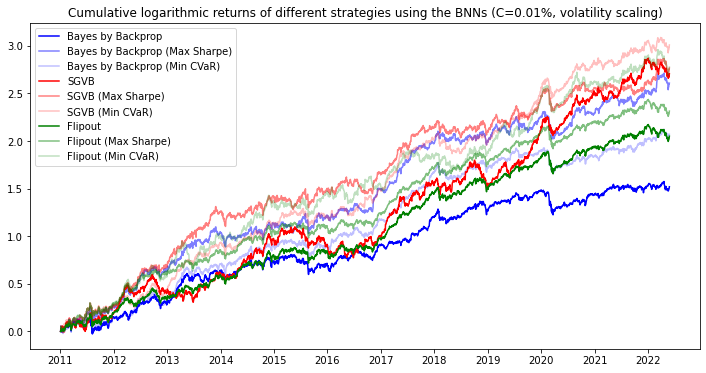

In [45]:
# plotting cumulative logarithmic returns of different strategies using the BNNs (C=0.01%, volatility scaling)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data['2011':].index, lcumrcv_bbb, label='Bayes by Backprop', c='b', alpha=1)
ax.plot(data['2011':].index, lcumrcv_bbb_ps, label='Bayes by Backprop (Max Sharpe)', c='b', alpha=0.5)
ax.plot(data['2011':].index, lcumrcv_bbb_cvar, label='Bayes by Backprop (Min CVaR)', c='b', alpha=0.25)
ax.plot(data['2011':].index, lcumrcv_sgvb, label='SGVB', c='r', alpha=1)
ax.plot(data['2011':].index, lcumrcv_sgvb_ps, label='SGVB (Max Sharpe)', c='r', alpha=0.5)
ax.plot(data['2011':].index, lcumrcv_sgvb_cvar, label='SGVB (Min CVaR)', c='r', alpha=0.25)
ax.plot(data['2011':].index, lcumrcv_flipout, label='Flipout', c='g', alpha=1)
ax.plot(data['2011':].index, lcumrcv_flipout_ps, label='Flipout (Max Sharpe)', c='g', alpha=0.5)
ax.plot(data['2011':].index, lcumrcv_flipout_cvar, label='Flipout (Min CVaR)', c='g', alpha=0.25)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_title('Cumulative logarithmic returns of different strategies using the BNNs (C=0.01%, volatility scaling)')
plt.legend()
plt.show()

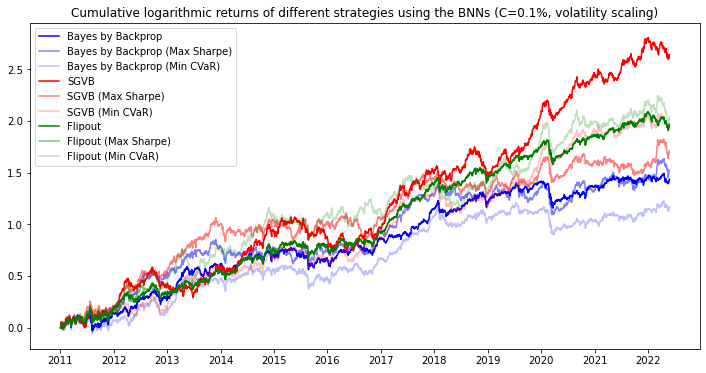

In [46]:
# plotting cumulative logarithmic returns of different strategies using the BNNs (C=0.1%, volatility scaling)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data['2011':].index, lcumrbcv_bbb, label='Bayes by Backprop', c='b', alpha=1)
ax.plot(data['2011':].index, lcumrbcv_bbb_ps, label='Bayes by Backprop (Max Sharpe)', c='b', alpha=0.5)
ax.plot(data['2011':].index, lcumrbcv_bbb_cvar, label='Bayes by Backprop (Min CVaR)', c='b', alpha=0.25)
ax.plot(data['2011':].index, lcumrbcv_sgvb, label='SGVB', c='r', alpha=1)
ax.plot(data['2011':].index, lcumrbcv_sgvb_ps, label='SGVB (Max Sharpe)', c='r', alpha=0.5)
ax.plot(data['2011':].index, lcumrbcv_sgvb_cvar, label='SGVB (Min CVaR)', c='r', alpha=0.25)
ax.plot(data['2011':].index, lcumrbcv_flipout, label='Flipout', c='g', alpha=1)
ax.plot(data['2011':].index, lcumrbcv_flipout_ps, label='Flipout (Max Sharpe)', c='g', alpha=0.5)
ax.plot(data['2011':].index, lcumrbcv_flipout_cvar, label='Flipout (Min CVaR)', c='g', alpha=0.25)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_title('Cumulative logarithmic returns of different strategies using the BNNs (C=0.1%, volatility scaling)')
plt.legend()
plt.show()

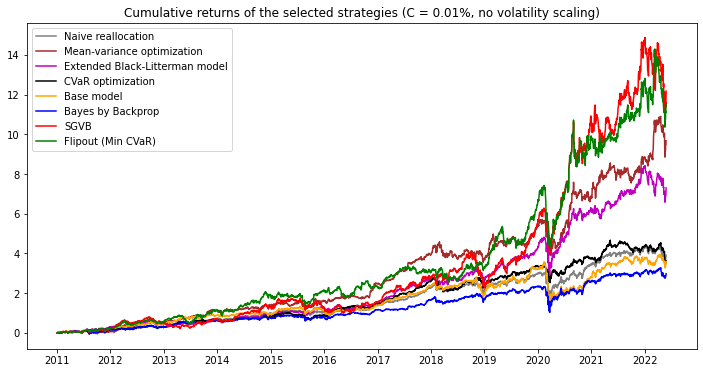

In [47]:
# plotting cumulative returns of the selected strategies (C = 0.01%, no volatility scaling)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data['2011':].index, cumrc_naive, label='Naive reallocation', c='grey')
ax.plot(data['2011':].index, cumrc_mvo, label='Mean-variance optimization', c='brown')
ax.plot(data['2011':].index, cumrc_eblmo, label='Extended Black-Litterman model', c='m')
ax.plot(data['2011':].index, cumrc_cvaro, label='CVaR optimization', c='black')
ax.plot(data['2011':].index, cumrc_base_rnn, label='Base model', c='orange')
ax.plot(data['2011':].index, cumrc_bbb, label='Bayes by Backprop', c='b')
ax.plot(data['2011':].index, cumrc_sgvb, label='SGVB', c='r')
ax.plot(data['2011':].index, cumrc_flipout_cvar, label='Flipout (Min CVaR)', c='g')

ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_title('Cumulative returns of the selected strategies (C = 0.01%, no volatility scaling)')
plt.legend()
plt.show()

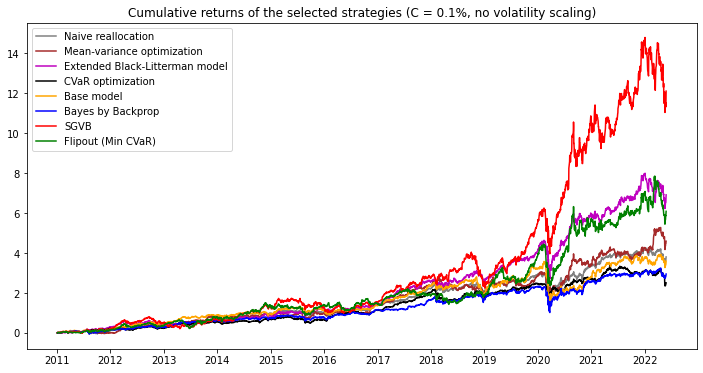

In [48]:
# plotting cumulative returns of the selected strategies (C = 0.1%, no volatility scaling)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data['2011':].index, cumrbc_naive, label='Naive reallocation', c='grey')
ax.plot(data['2011':].index, cumrbc_mvo, label='Mean-variance optimization', c='brown')
ax.plot(data['2011':].index, cumrbc_eblmo, label='Extended Black-Litterman model', c='m')
ax.plot(data['2011':].index, cumrbc_cvaro, label='CVaR optimization', c='black')
ax.plot(data['2011':].index, cumrbc_base_rnn, label='Base model', c='orange')
ax.plot(data['2011':].index, cumrbc_bbb, label='Bayes by Backprop', c='b')
ax.plot(data['2011':].index, cumrbc_sgvb, label='SGVB', c='r')
ax.plot(data['2011':].index, cumrbc_flipout_cvar, label='Flipout (Min CVaR)', c='g')

ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_title('Cumulative returns of the selected strategies (C = 0.1%, no volatility scaling)')
plt.legend()
plt.show()

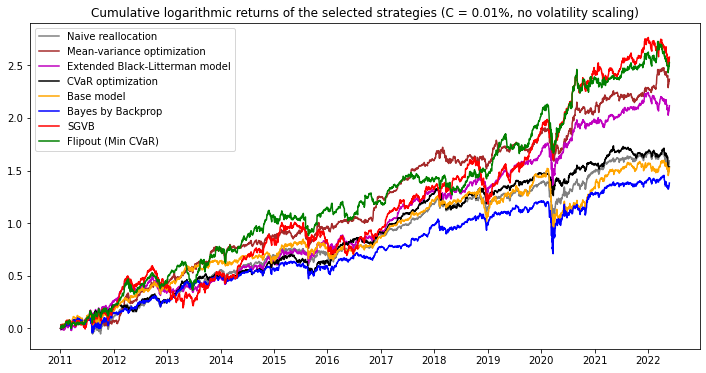

In [49]:
# plotting cumulative logarithmic returns of the selected strategies (C = 0.01%, no volatility scaling)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data['2011':].index, lcumrc_naive, label='Naive reallocation', c='grey')
ax.plot(data['2011':].index, lcumrc_mvo, label='Mean-variance optimization', c='brown')
ax.plot(data['2011':].index, lcumrc_eblmo, label='Extended Black-Litterman model', c='m')
ax.plot(data['2011':].index, lcumrc_cvaro, label='CVaR optimization', c='black')
ax.plot(data['2011':].index, lcumrc_base_rnn, label='Base model', c='orange')
ax.plot(data['2011':].index, lcumrc_bbb, label='Bayes by Backprop', c='b')
ax.plot(data['2011':].index, lcumrc_sgvb, label='SGVB', c='r')
ax.plot(data['2011':].index, lcumrc_flipout_cvar, label='Flipout (Min CVaR)', c='g')

ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_title('Cumulative logarithmic returns of the selected strategies (C = 0.01%, no volatility scaling)')
plt.legend()
plt.show()

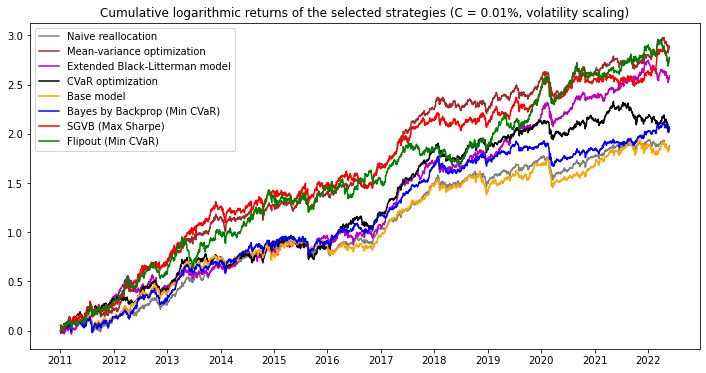

In [50]:
# plotting cumulative logarithmic returns of the selected strategies (C = 0.01%, volatility scaling)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data['2011':].index, lcumrcv_naive, label='Naive reallocation', c='grey')
ax.plot(data['2011':].index, lcumrcv_mvo, label='Mean-variance optimization', c='brown')
ax.plot(data['2011':].index, lcumrcv_eblmo, label='Extended Black-Litterman model', c='m')
ax.plot(data['2011':].index, lcumrcv_cvaro, label='CVaR optimization', c='black')
ax.plot(data['2011':].index, lcumrcv_base_rnn, label='Base model', c='orange')
ax.plot(data['2011':].index, lcumrcv_bbb_cvar, label='Bayes by Backprop (Min CVaR)', c='b')
ax.plot(data['2011':].index, lcumrcv_sgvb_ps, label='SGVB (Max Sharpe)', c='r')
ax.plot(data['2011':].index, lcumrcv_flipout_cvar, label='Flipout (Min CVaR)', c='g')

ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_title('Cumulative logarithmic returns of the selected strategies (C = 0.01%, volatility scaling)')
plt.legend()
plt.show()

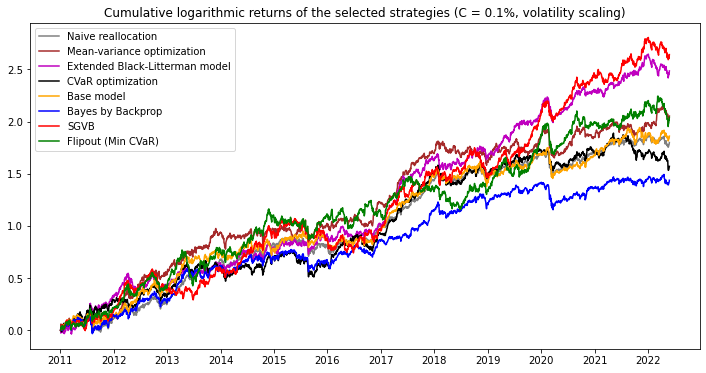

In [51]:
# plotting cumulative logarithmic returns of the selected strategies (C = 0.1%, volatility scaling)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data['2011':].index, lcumrbcv_naive, label='Naive reallocation', c='grey')
ax.plot(data['2011':].index, lcumrbcv_mvo, label='Mean-variance optimization', c='brown')
ax.plot(data['2011':].index, lcumrbcv_eblmo, label='Extended Black-Litterman model', c='m')
ax.plot(data['2011':].index, lcumrbcv_cvaro, label='CVaR optimization', c='black')
ax.plot(data['2011':].index, lcumrbcv_base_rnn, label='Base model', c='orange')
ax.plot(data['2011':].index, lcumrbcv_bbb, label='Bayes by Backprop', c='b')
ax.plot(data['2011':].index, lcumrbcv_sgvb, label='SGVB', c='r')
ax.plot(data['2011':].index, lcumrbcv_flipout_cvar, label='Flipout (Min CVaR)', c='g')

ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_title('Cumulative logarithmic returns of the selected strategies (C = 0.1%, volatility scaling)')
plt.legend()
plt.show()

### Plots of portfolio weights and standard deviation of BNN output throughout the evaluation period

#### Visualization of portfolio structures

In [52]:
# dataframes of portfolio weights with datetime index for furthter plotting

weights_naive = pd.DataFrame(data = naive_weights, index=data['2011':].index, columns=data['2011':].columns)
weights_mvo = pd.DataFrame(data = mvo_weights, index=data['2011':].index, columns=data['2011':].columns)
weights_eblmo = pd.DataFrame(data = eblmo_weights, index=data['2011':].index, columns=data['2011':].columns)
weights_cvaro = pd.DataFrame(data = cvaro_weights, index=data['2011':].index, columns=data['2011':].columns)
weights_base = pd.DataFrame(data = portfolio_weights_mean[0], index=data['2011':].index, columns=data['2011':].columns)
weights_bbb = pd.DataFrame(data = portfolio_weights_mean[1], index=data['2011':].index, columns=data['2011':].columns)
weights_sgvb = pd.DataFrame(data = portfolio_weights_mean[2], index=data['2011':].index, columns=data['2011':].columns)
weights_flipout = pd.DataFrame(data = portfolio_weights_mean[3], index=data['2011':].index, columns=data['2011':].columns)
weights_bbb_ps = pd.DataFrame(data = portfolio_weights_ps[0], index=data['2011':].index, columns=data['2011':].columns)
weights_sgvb_ps = pd.DataFrame(data = portfolio_weights_ps[1], index=data['2011':].index, columns=data['2011':].columns)
weights_flipout_ps = pd.DataFrame(data = portfolio_weights_ps[2], index=data['2011':].index, columns=data['2011':].columns)
weights_bbb_cvar = pd.DataFrame(data = portfolio_weights_cvar[0], index=data['2011':].index, columns=data['2011':].columns)
weights_sgvb_cvar = pd.DataFrame(data = portfolio_weights_cvar[1], index=data['2011':].index, columns=data['2011':].columns)
weights_flipout_cvar = pd.DataFrame(data = portfolio_weights_cvar[2], index=data['2011':].index, columns=data['2011':].columns)

C:\Users\Makar\AppData\Local\Temp\ipykernel_18252\2068095310.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])


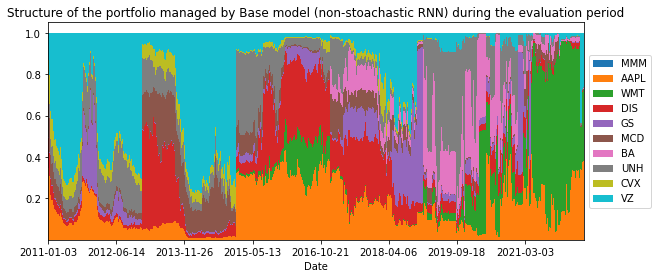

In [53]:
# plotting structure of the portfolio managed by Base model (non-stoachastic RNN) during the evaluation period

ax = weights_base.plot(kind='bar', stacked=True, width=1, figsize=(12,4), colormap='tab10', xticks=None, rot=0)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_title('Structure of the portfolio managed by Base model (non-stoachastic RNN) during the evaluation period')
plt.show()

C:\Users\Makar\AppData\Local\Temp\ipykernel_18252\15420083.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])


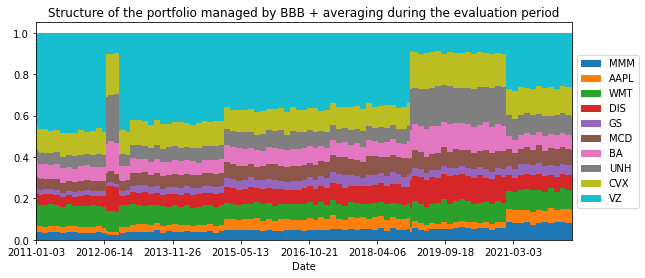

In [54]:
# plotting structure of the portfolio managed by BBB + averaging during the evaluation period

ax = weights_bbb.plot(kind='bar', stacked=True, width=1, figsize=(12,4), colormap='tab10', xticks=None, rot=0)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Structure of the portfolio managed by BBB + averaging during the evaluation period')
plt.show()

C:\Users\Makar\AppData\Local\Temp\ipykernel_18252\488756369.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])


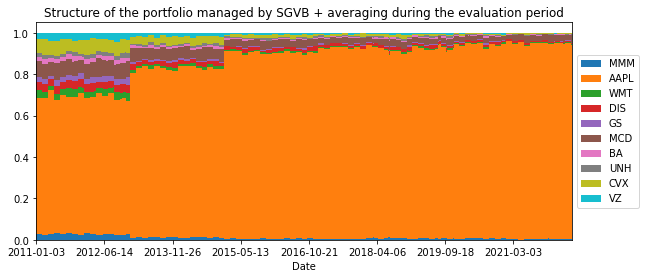

In [55]:
# plotting structure of the portfolio managed by SGVB + averaging during the evaluation period
ax = weights_sgvb.plot(kind='bar', stacked=True, width=1, figsize=(12, 4), colormap='tab10', xticks=None, rot=0)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_title('Structure of the portfolio managed by SGVB + averaging during the evaluation period')
plt.show()

C:\Users\Makar\AppData\Local\Temp\ipykernel_18252\2243146924.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])


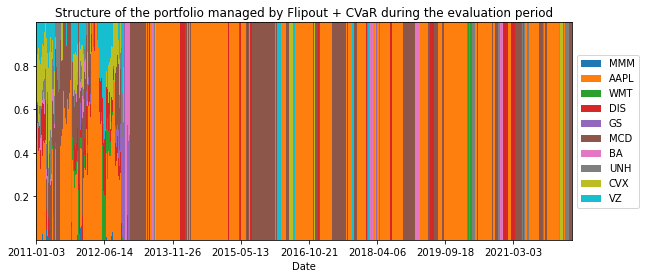

In [56]:
# plotting structure of the portfolio managed by Flipout + CVaR during the evaluation period
ax = weights_flipout_cvar.plot(kind='bar', stacked=True, width=1, figsize=(12, 4), colormap='tab10', xticks=None, rot=0)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_title('Structure of the portfolio managed by Flipout + CVaR during the evaluation period')
plt.show()

C:\Users\Makar\AppData\Local\Temp\ipykernel_18252\1014971091.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])


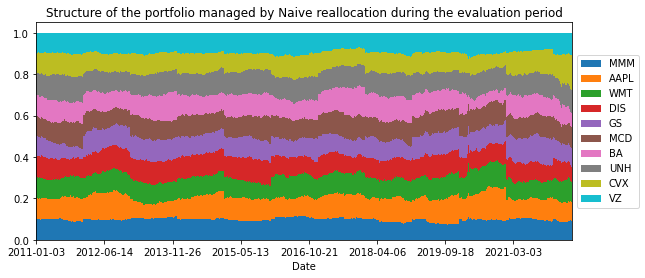

In [57]:
# plotting structure of the portfolio managed by Naive reallocation during the evaluation period
ax = weights_naive.plot(kind='bar', stacked=True, width=1, figsize=(12,4), colormap='tab10', xticks=None, rot=0)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_title('Structure of the portfolio managed by Naive reallocation during the evaluation period')
plt.show()

C:\Users\Makar\AppData\Local\Temp\ipykernel_18252\3125223781.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])


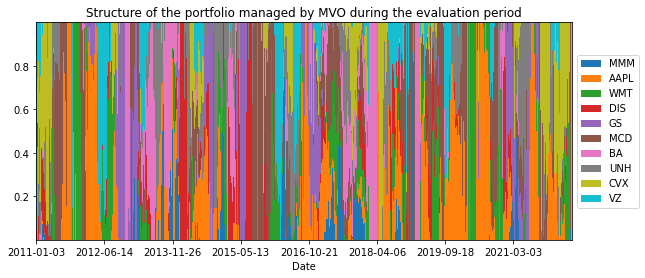

In [58]:
# plotting structure of the portfolio managed by MVO during the evaluation period
ax = weights_mvo.plot(kind='bar', stacked=True, width=1, figsize=(12,4), colormap='tab10', xticks=None, rot=0)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_title('Structure of the portfolio managed by MVO during the evaluation period')
plt.show()

C:\Users\Makar\AppData\Local\Temp\ipykernel_18252\1231439876.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])


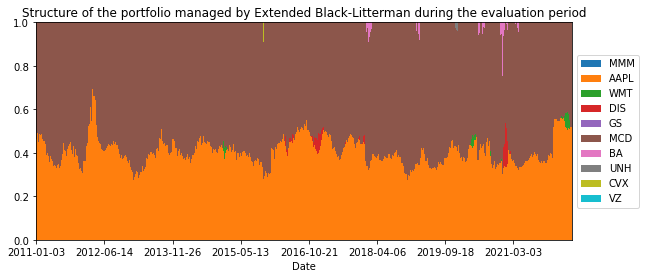

In [59]:
# plotting structure of the portfolio managed by Extended Black-Litterman during the evaluation period
ax = weights_eblmo.plot(kind='bar', stacked=True, width=1, figsize=(12,4), colormap='tab10', xticks=None, rot=0)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_title('Structure of the portfolio managed by Extended Black-Litterman during the evaluation period')
plt.show()

C:\Users\Makar\AppData\Local\Temp\ipykernel_18252\614721512.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])


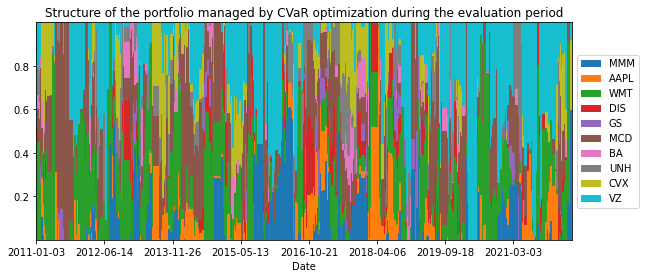

In [60]:
# plotting structure of the portfolio managed by CVaR optimization during the evaluation period
ax = weights_cvaro.plot(kind='bar', stacked=True, width=1, figsize=(12,4), colormap='tab10', xticks=None, rot=0)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_title('Structure of the portfolio managed by CVaR optimization during the evaluation period')
plt.show()

C:\Users\Makar\AppData\Local\Temp\ipykernel_18252\2799940072.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])


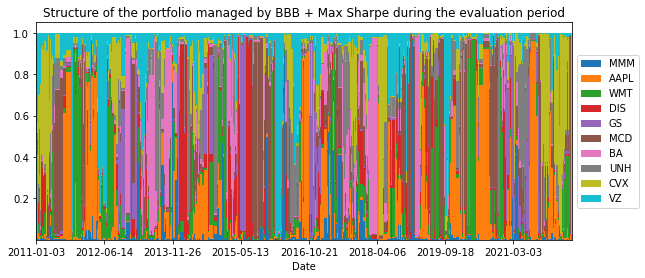

In [61]:
# plotting structure of the portfolio managed by BBB + Max Sharpe during the evaluation period
ax = weights_bbb_ps.plot(kind='bar', stacked=True, width=1, figsize=(12,4), colormap='tab10', xticks=None, rot=0)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_title('Structure of the portfolio managed by BBB + Max Sharpe during the evaluation period')
plt.show()

C:\Users\Makar\AppData\Local\Temp\ipykernel_18252\2549063676.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])


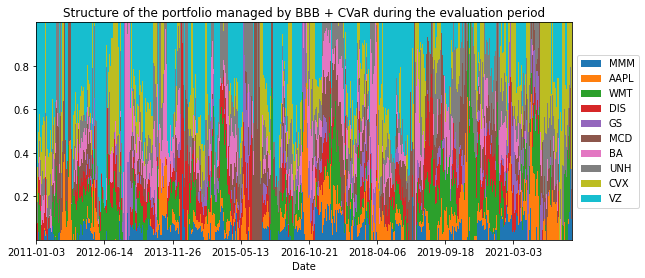

In [62]:
# plotting structure of the portfolio managed by BBB + CVaR during the evaluation period
ax = weights_bbb_cvar.plot(kind='bar', stacked=True, width=1, figsize=(12,4), colormap='tab10', xticks=None, rot=0)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_title('Structure of the portfolio managed by BBB + CVaR during the evaluation period')
plt.show()

C:\Users\Makar\AppData\Local\Temp\ipykernel_18252\588987558.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])


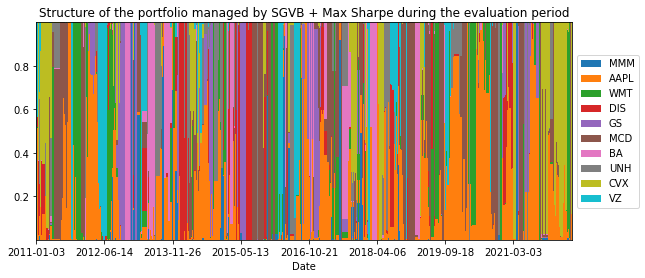

In [63]:
# plotting structure of the portfolio managed by SGVB + Max Sharpe during the evaluation period
ax = weights_sgvb_ps.plot(kind='bar', stacked=True, width=1, figsize=(12,4), colormap='tab10', xticks=None, rot=0)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_title('Structure of the portfolio managed by SGVB + Max Sharpe during the evaluation period')
plt.show()

C:\Users\Makar\AppData\Local\Temp\ipykernel_18252\4061686651.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])


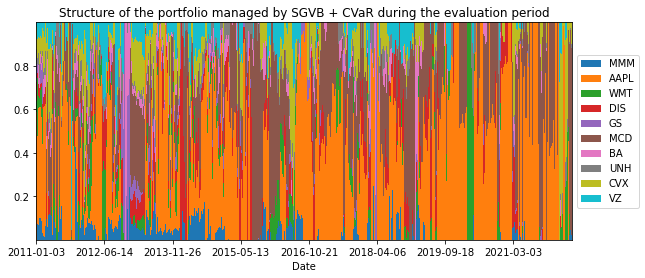

In [64]:
# plotting structure of the portfolio managed by SGVB + CVaR during the evaluation period
ax = weights_sgvb_cvar.plot(kind='bar', stacked=True, width=1, figsize=(12,4), colormap='tab10', xticks=None, rot=0)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_title('Structure of the portfolio managed by SGVB + CVaR during the evaluation period')
plt.show()

C:\Users\Makar\AppData\Local\Temp\ipykernel_18252\3355481495.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])


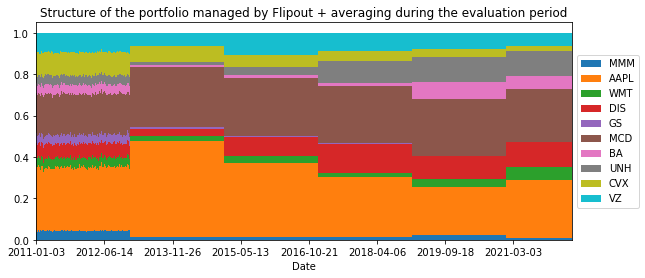

In [65]:
# plotting structure of the portfolio managed by Flipout + averaging during the evaluation period
ax = weights_flipout.plot(kind='bar', stacked=True, width=1, figsize=(12,4), colormap='tab10', xticks=None, rot=0)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_title('Structure of the portfolio managed by Flipout + averaging during the evaluation period')
plt.show()

C:\Users\Makar\AppData\Local\Temp\ipykernel_18252\1706434337.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])


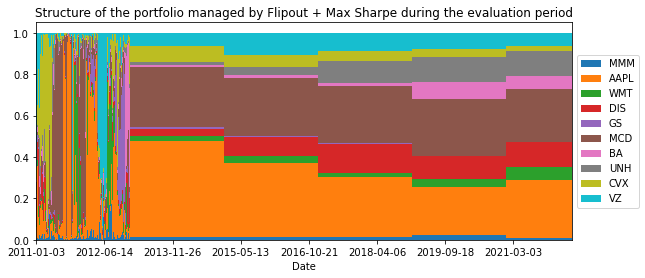

In [66]:
# plotting structure of the portfolio managed by Flipout + Max Sharpe during the evaluation period
ax = weights_flipout_ps.plot(kind='bar', stacked=True, width=1, figsize=(12,4), colormap='tab10', xticks=None, rot=0)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_xticklabels(['0','2011-01-03', '2012-06-14','2013-11-26','2015-05-13','2016-10-21','2018-04-06','2019-09-18','2021-03-03'])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_title('Structure of the portfolio managed by Flipout + Max Sharpe during the evaluation period')
plt.show()

#### Visualization of BNN uncertainty

In [67]:
# dataframes of portfolio weight SDs and RSDs (relative standard deviation) with datetime index for furthter plotting

stds_bbb = pd.DataFrame(data = weight_stds[0], index=data['2011':].index, columns=data['2011':].columns)
stds_sgvb = pd.DataFrame(data = weight_stds[1], index=data['2011':].index, columns=data['2011':].columns)
stds_flipout = pd.DataFrame(data = weight_stds[2], index=data['2011':].index, columns=data['2011':].columns)

rstds_bbb = pd.DataFrame(weight_stds[0]/portfolio_weights_mean[1], index=data['2011':].index, columns=data['2011':].columns)
rstds_sgvb = pd.DataFrame(weight_stds[1]/portfolio_weights_mean[2], index=data['2011':].index, columns=data['2011':].columns)
rstds_flipout = pd.DataFrame(weight_stds[2]/portfolio_weights_mean[3], index=data['2011':].index, columns=data['2011':].columns)

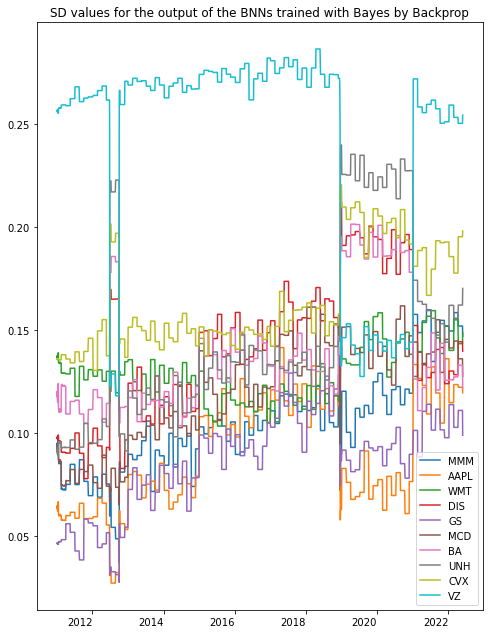

In [68]:
# plotting the SD values for the output of the BNNs trained with Bayes by Backprop 
stds_bbb.plot(figsize=(8,12), colormap='tab10', xlabel='', rot=0)
plt.title('SD values for the output of the BNNs trained with Bayes by Backprop')
plt.show()

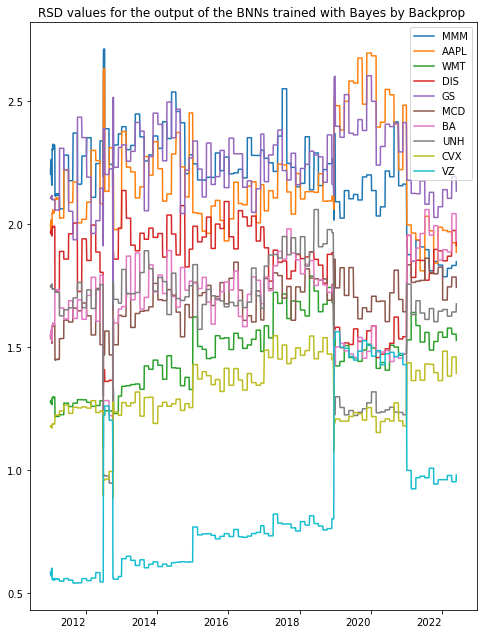

In [69]:
# plotting the RSD values for the output of the BNNs trained with Bayes by Backprop 
rstds_bbb.plot(figsize=(8, 12), colormap='tab10', xlabel='', rot=0)
plt.title('RSD values for the output of the BNNs trained with Bayes by Backprop ')
plt.show()

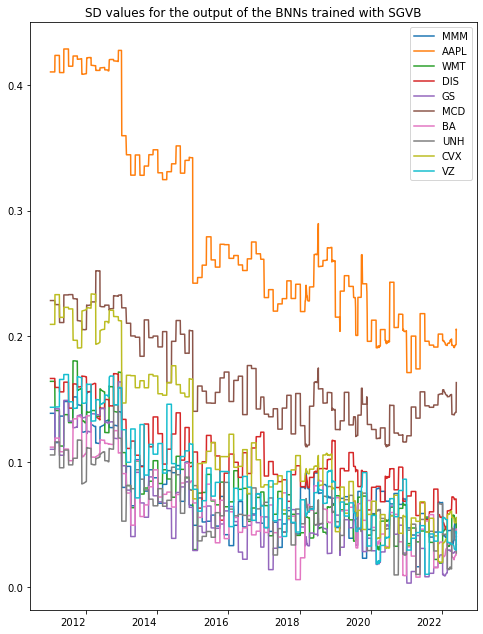

In [70]:
# plotting the SD values for the output of the BNNs trained with SGVB
stds_sgvb.plot(figsize=(8,12), colormap='tab10', xlabel='', rot=0)
plt.title('SD values for the output of the BNNs trained with SGVB')
plt.show()

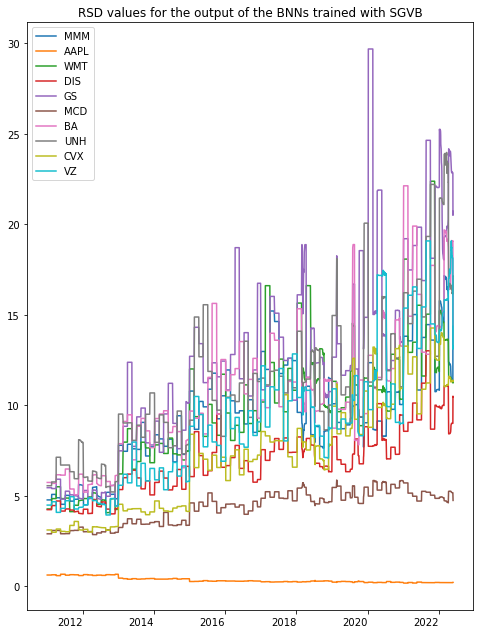

In [71]:
# plotting the RSD values for the output of the BNNs trained with SGVB
rstds_sgvb.plot(figsize=(8,12), colormap='tab10', xlabel='', rot=0)
plt.title('RSD values for the output of the BNNs trained with SGVB')
plt.show()

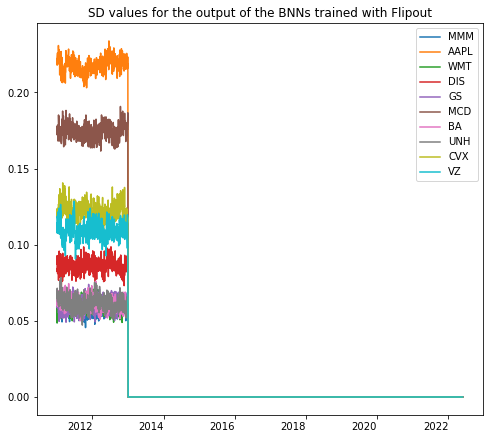

In [72]:
# plotting the SD values for the output of the BNNs trained with Flipout
stds_flipout.plot(figsize=(8,8), colormap='tab10', xlabel='', rot=0)
plt.title('SD values for the output of the BNNs trained with Flipout')
plt.show()

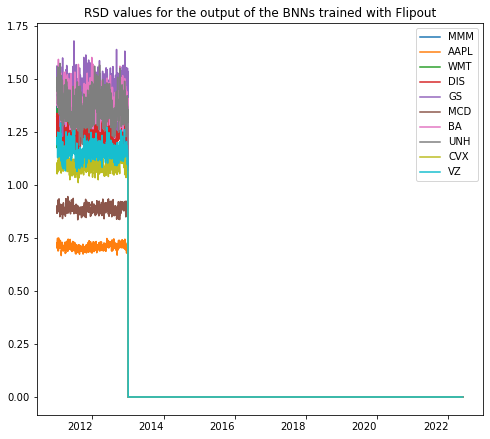

In [73]:
# plotting the RSD values for the output of the BNNs trained with Flipout
rstds_flipout.plot(figsize=(8,8), colormap='tab10', xlabel='', rot=0)
plt.title('RSD values for the output of the BNNs trained with Flipout')
plt.show()